In [350]:
import pandas as pd 
import numpy as np # linear algebra
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport as PR
%matplotlib inline

# Work package 1

In this work package, the purpose is to preprocess the data, and select the relervant features for developing a classification model. There are a few tasks in this work package:
* Task 1: Cleaning. In this task, the aim is to clean the data by removing/imputating the missing values and outliers. 
* Task 2: Preprocessing. The aim of this task is to encode the categorical features and combine them with the numerical features. Also, we need to scale the numerical features.
* Task 3: Feature selection. The aim of this task is to decide which features are relervant and needs to be used in the classification model to be developed.

In this section, you need to present the following (with code and texts to explain):
1. Data preprocessing: How do you clean and preprocess the data.
2.  Feature engineering: What are the features you selected and how do you select them.

## Reading the data.

The original data are stored in an excel file. In the supporting script utility.py, we provide you with a supproting function read_data, which can read the origial data and tranform it into a DataFrame for easy use.

In [351]:
from utility import read_data

file_name = 'Excel - Jeu de données 30min.xlsx'
df_data_org = read_data(file_name)

test


In [352]:
df_data_org.head(10)

,VIB1: aRMS min,VIB1: aRMS avg,VIB1: aRMS max,VIB1: vRMS min,VIB1: vRMS avg,VIB1: vRMS max,VIB1: DKW min,VIB1: DKW avg,VIB1: DKW max,VIB1: aPeak min,VIB1: aPeak avg,VIB1: aPeak max,Label,Speed
0,0.095028,0.108673,0.124450,0.028452,0.103652,0.840367,0.000235,0.002229,0.004425,0.019680,0.152843,0.289421,0,100
1,0.114830,0.116392,0.119189,0.022256,0.065612,0.318523,0.002731,0.003595,0.006944,0.187470,0.245774,0.472644,0,100
2,0.115623,0.116716,0.118186,0.020222,0.038325,0.295456,0.002918,0.003596,0.006187,0.197608,0.245268,0.424281,0,100
3,0.116281,0.118019,0.119925,0.020494,0.021857,0.024859,0.002772,0.003589,0.005595,0.187848,0.242001,0.376719,0,100
4,0.117399,0.119179,0.121064,0.018967,0.031151,0.116402,0.002744,0.003860,0.014931,0.185445,0.257477,0.981690,0,100
5,0.117801,0.120088,0.121385,0.019339,0.021165,0.023875,0.002446,0.003696,0.007134,0.162313,0.244888,0.470853,0,100
6,0.119973,0.121245,0.122769,0.018367,0.020098,0.025943,0.002446,0.003975,0.008013,0.162313,0.260925,0.523719,0,100
7,0.120086,0.121471,0.123690,0.017371,0.020301,0.025252,0.002654,0.004439,0.028653,0.175149,0.290388,1.850730,0,100
8,0.121960,0.125248,0.135252,0.020031,0.021623,0.024422,0.003321,0.012901,0.100119,0.213721,0.804334,5.951260,0,100
9,0.121968,0.128777,0.140647,0.018936,0.073434,0.716553,0.003154,0.029169,0.101640,0.205839,1.772610,5.752400,0,100


In [353]:
print(df_data_org.size)
print(df_data_org.shape)

2520
(180, 14)


We can print the first 10 rows of the dataset. We can see that:
* The first 12 columns are the features collected from sensor.
* Label: 0 - Not failure, 1 - Failure.
* Speed: Rotation speed.

We can visualize the data, by drawing the time series of each feature, under each speed condition and failure state.

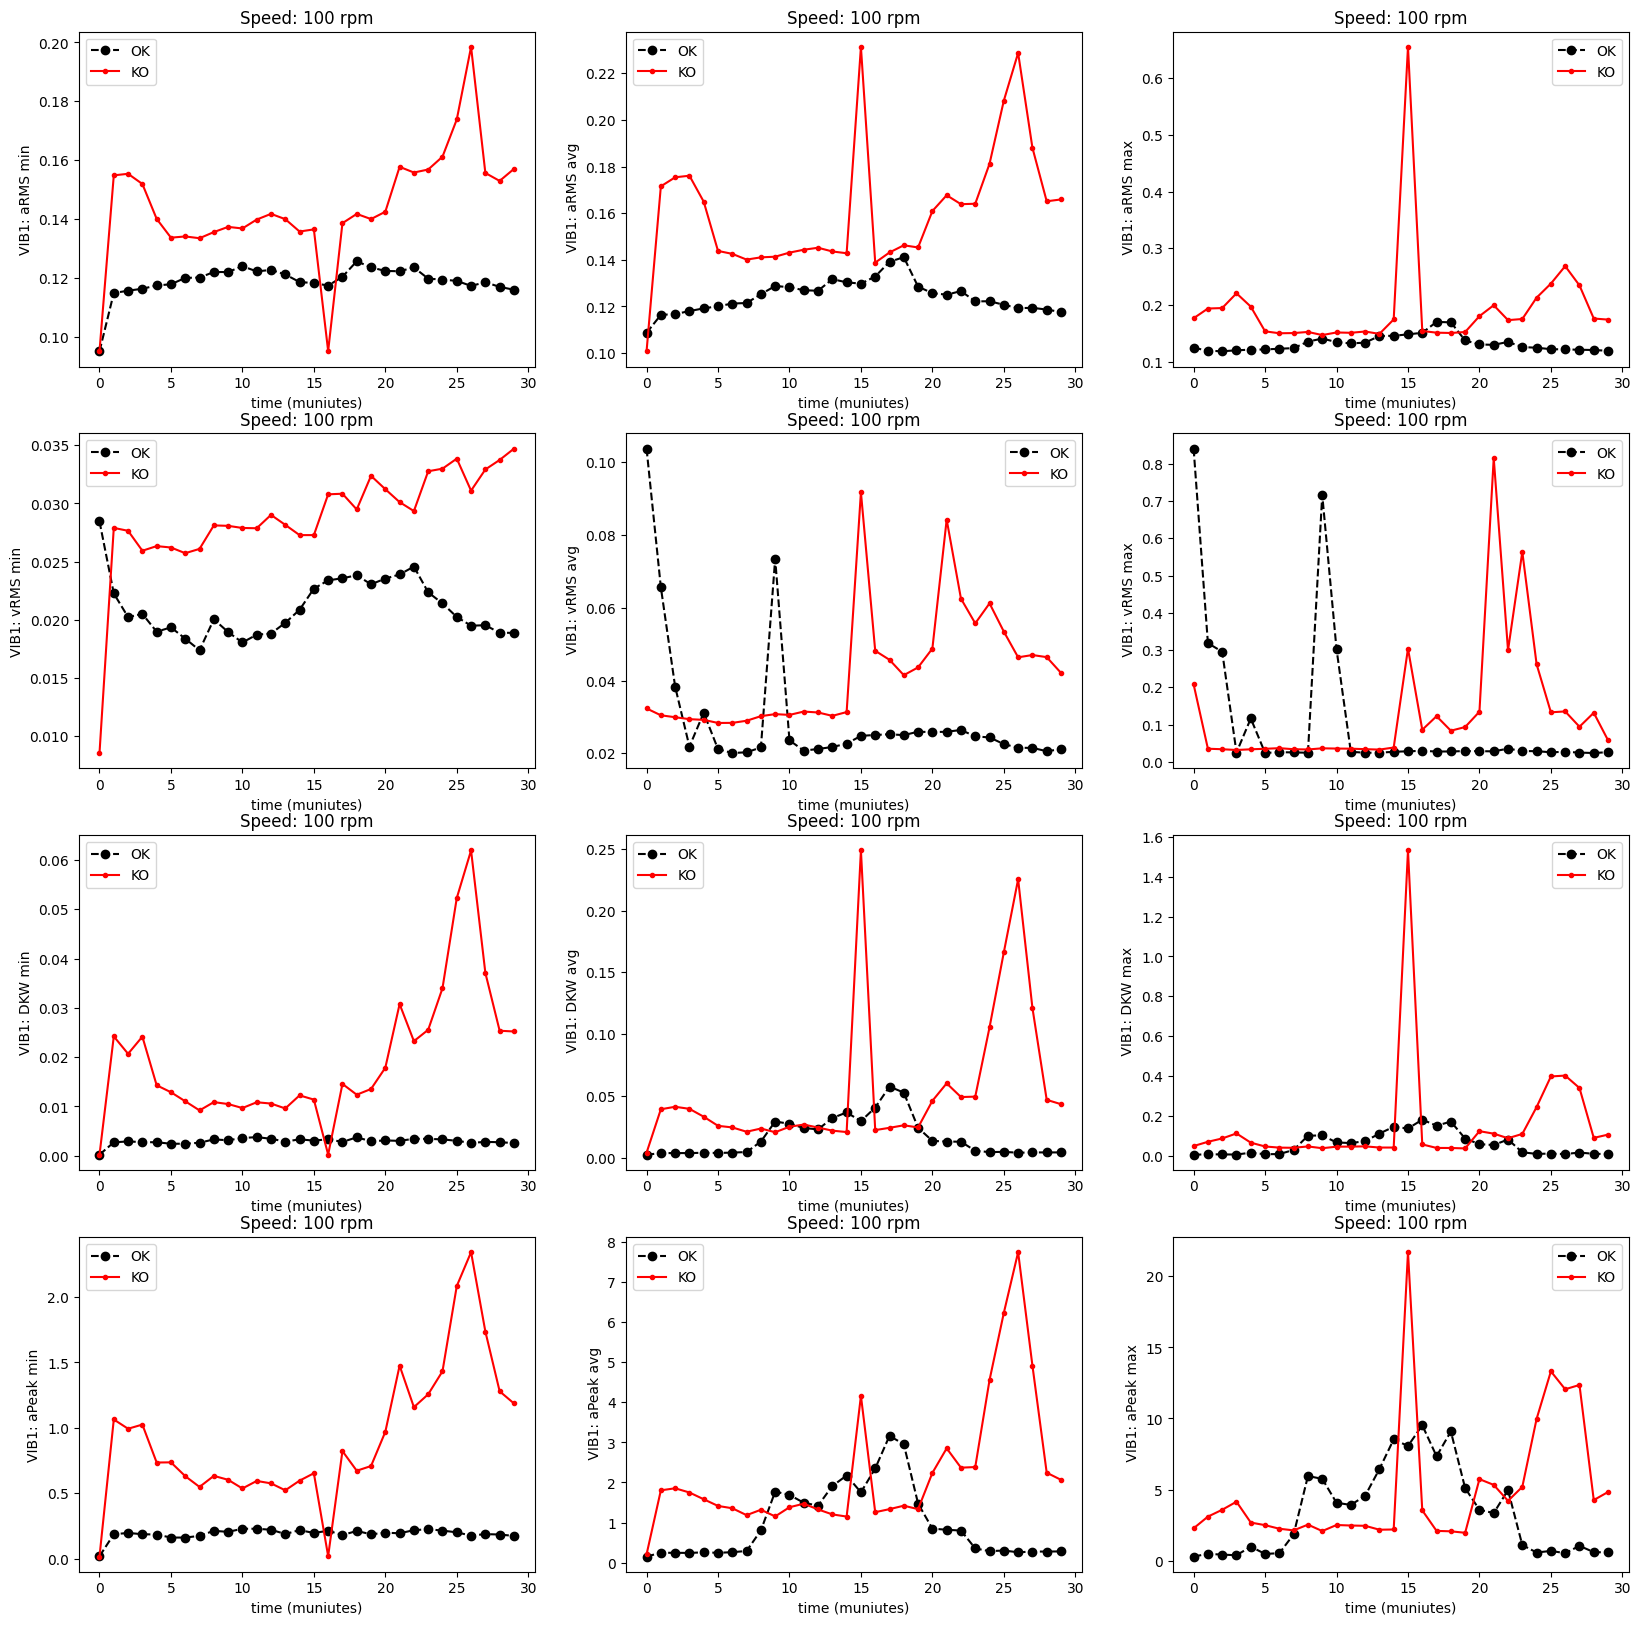

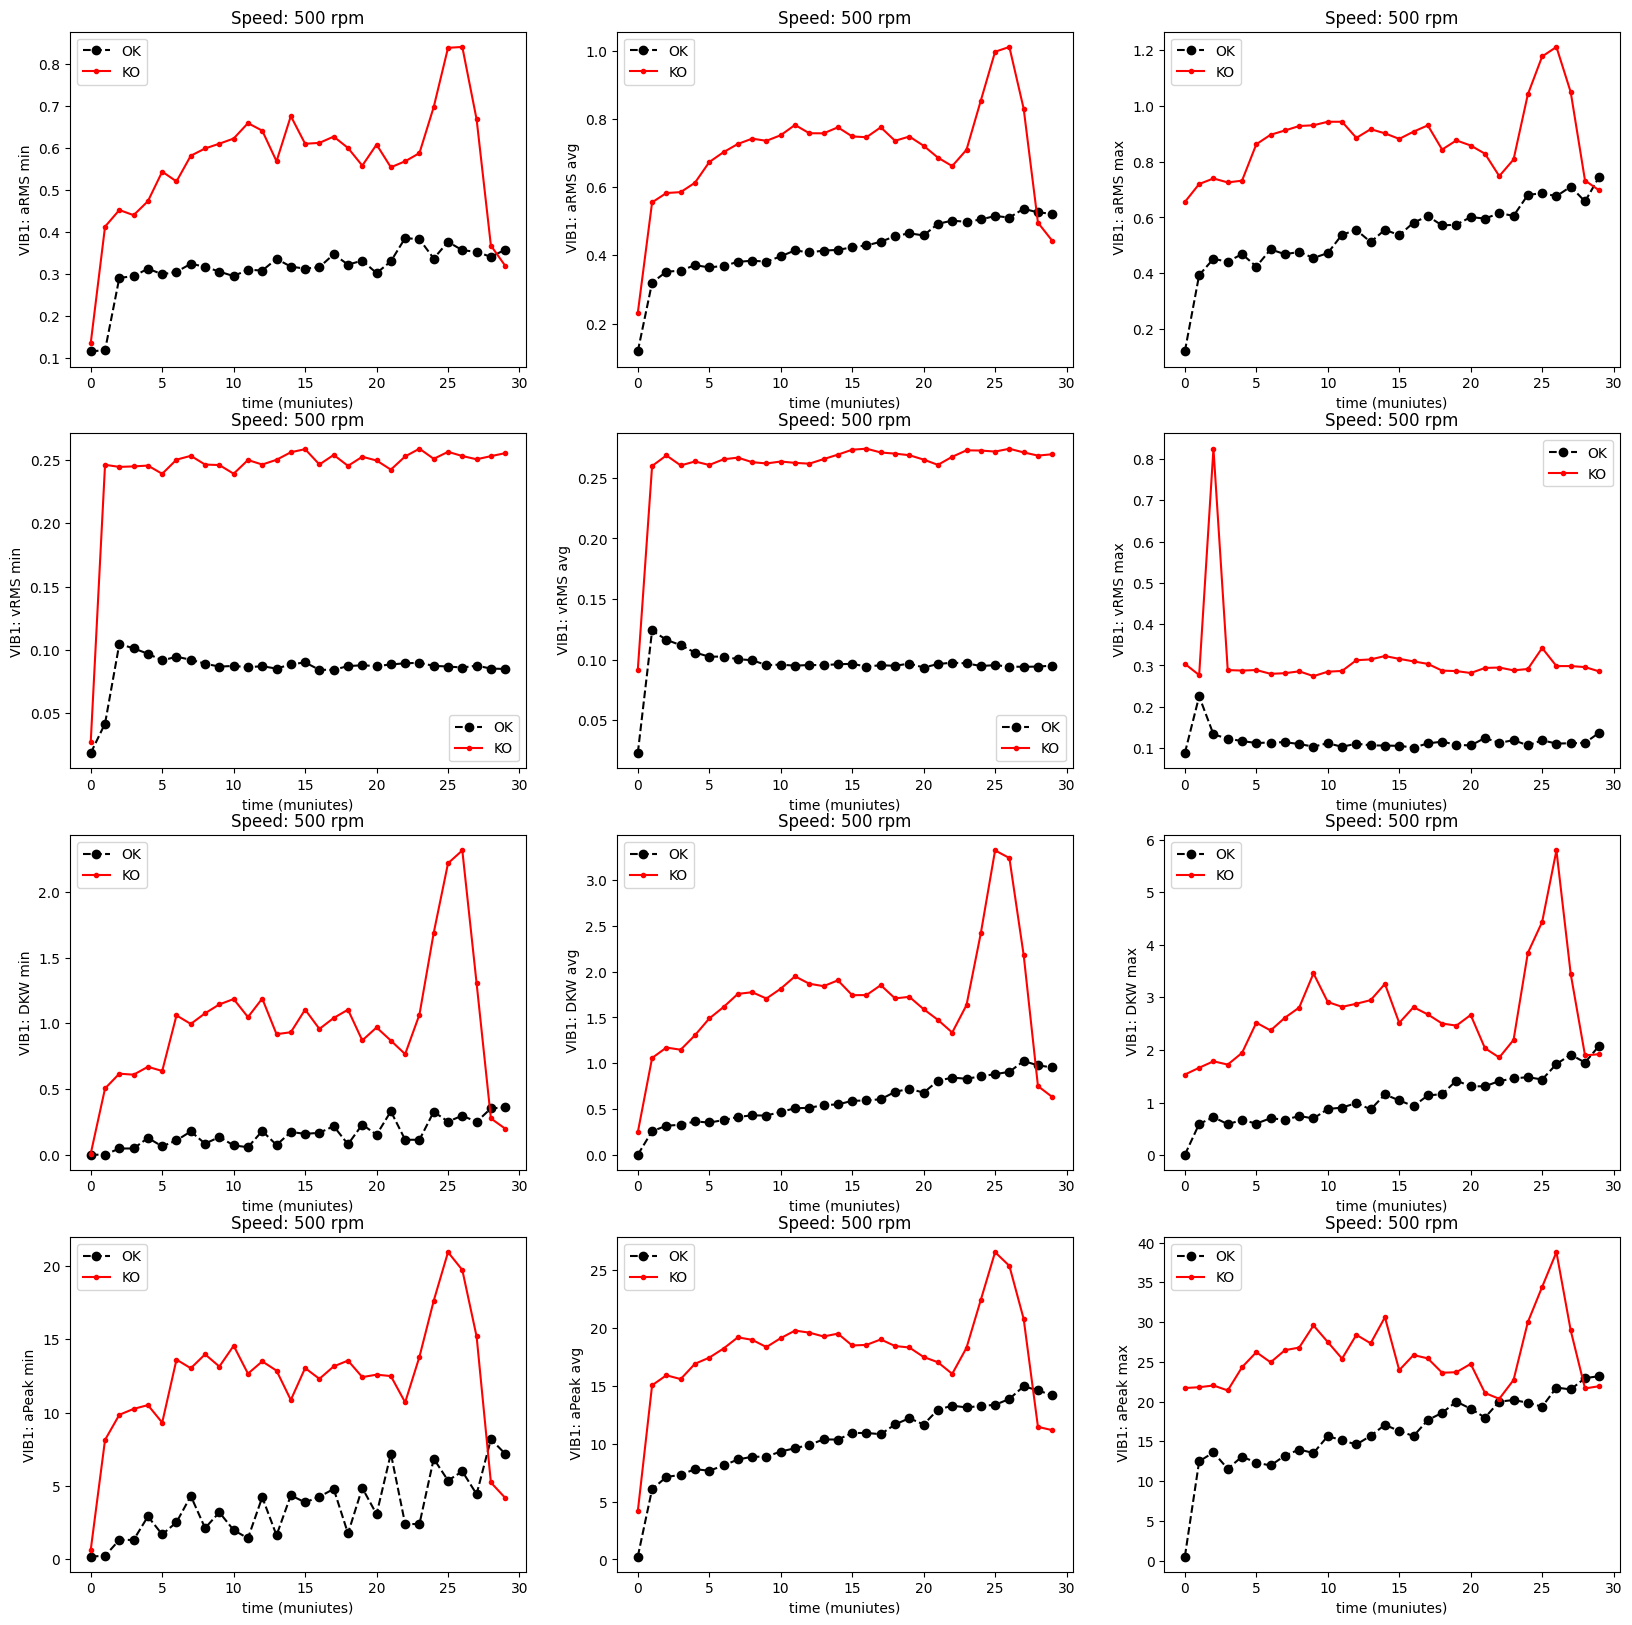

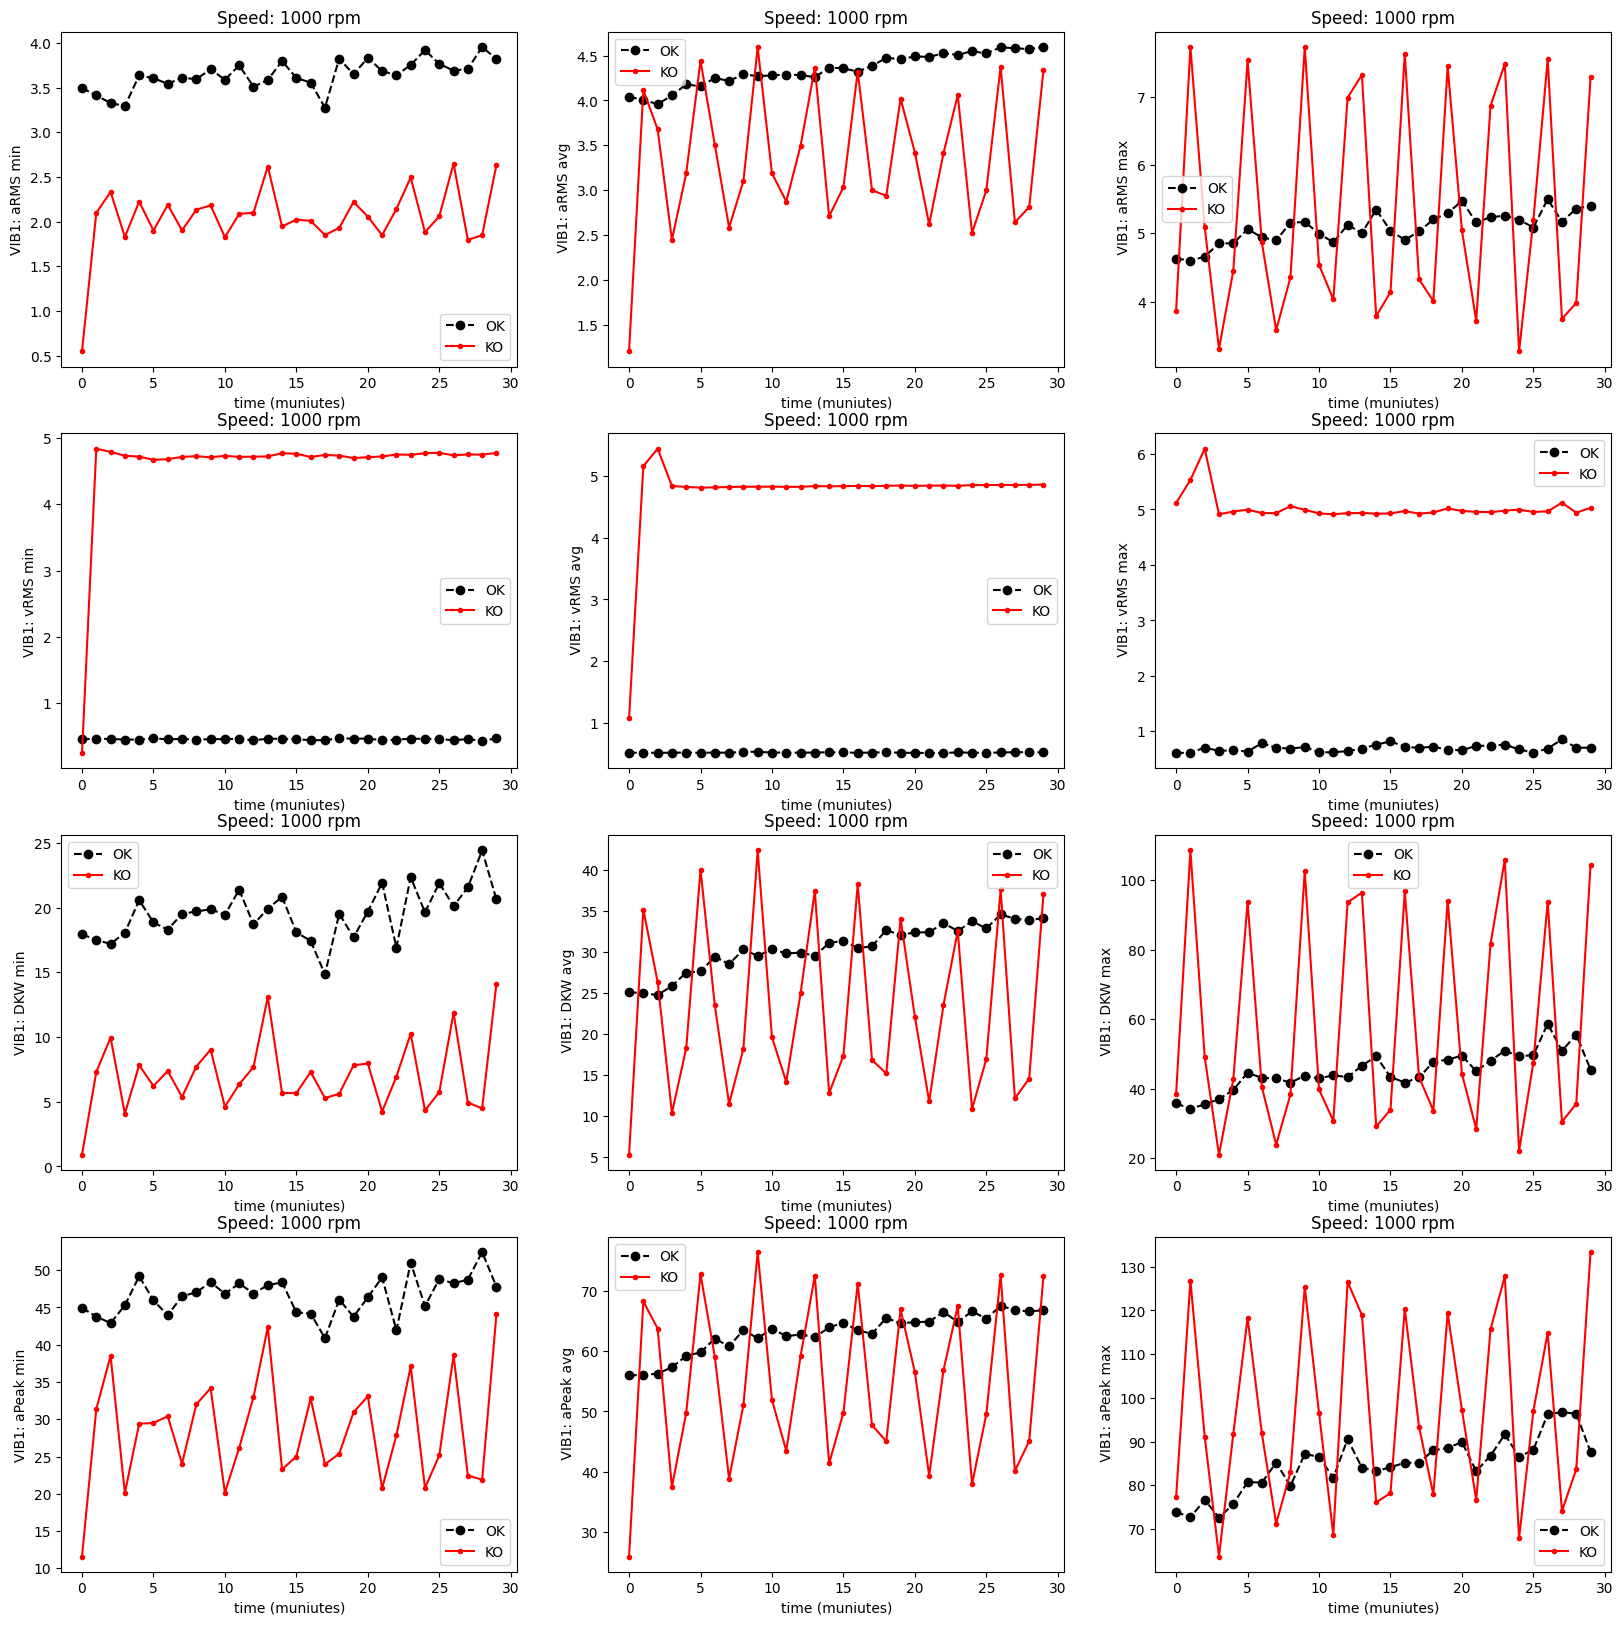

In [354]:
import numpy as np
import matplotlib.pyplot as plt

for speed in [100, 500, 1000]:
    fig, ax = plt.subplots(4, 3, figsize=(20, 20))
    i, j = 0, 0
    for feature in df_data_org.columns[:12]:
        ax[i,j].plot(np.arange(30), df_data_org[(df_data_org['Label']==0) & (df_data_org['Speed']==speed)][feature], '--ko', 
            np.arange(30), df_data_org[(df_data_org['Label']==1) & (df_data_org['Speed']==speed)][feature], '-r.')
        ax[i,j].set_xlabel('time (muniutes)')
        ax[i,j].set_ylabel(feature)
        ax[i,j].set_title('Speed: {} rpm'.format(speed))
        ax[i,j].legend(['OK', 'KO'])

        j+=1
        if j==3:
            i+=1
            j=0

# Task 1: Cleaning

## Missing values
When we have the original data, we often start by checking if the dataset contain some missing values. If so, we could either remove them, or replace them with some selected values (like means, mode, etc). For a tutorial, you can find it here: https://colab.research.google.com/drive/18eOdS_fTbM7gOzuRfZWHZ_2OqTTf6a1z

We use the isnull() function to check for missing values. For a reference, see here: https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/

You can see from the results, we are lucky to have no missing values in our dataset.

In [355]:
df_data_org.isnull().values.any()

False

## Outlier

The next step is to define a method to remove the potential outliers in the numerical features. As we discussed in the video class, an easy way to detect outlier is through statistical approaches: Fit a statistical distribution to all the data, then, the data point which exceed a upper or lower quartitile will be regarded as outlier. If we fit a normal distribution, then, this leads to the so-called Z-score approach: https://www.analyticsvidhya.com/blog/2022/08/dealing-with-outliers-using-the-z-score-method/.

After identifying the outlier, you also need to choose your strategy to handle them. You can simply remove them, but you will lose some information because maybe only one feature is affected by the outlier. An alternative approach is to treat this outlier as a missing value, and fill it with some pre-selected numbers (e.g., the mean of the feature): https://colab.research.google.com/drive/18eOdS_fTbM7gOzuRfZWHZ_2OqTTf6a1z


In [356]:
# Get the features and labels.
X_org = df_data_org.iloc[:, :12]
y = df_data_org['Label']

In [357]:
def handle_outlier(x):
    ul = x.mean() + 3*x.std()
    ll = x.mean() - 3*x.std()
    x[(x>ul) | (x<ll)] = x.mean()

    return x

X = X_org.copy(deep=True)
df_data = df_data_org.copy(deep=True)
for speed in [100, 500, 1000]:
    for label in [0, 1]:    
        for col in X_org.columns:
            x = X.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed), col]
            x = handle_outlier(x)
            X.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed), col] = x
            df_data.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed), col] = x

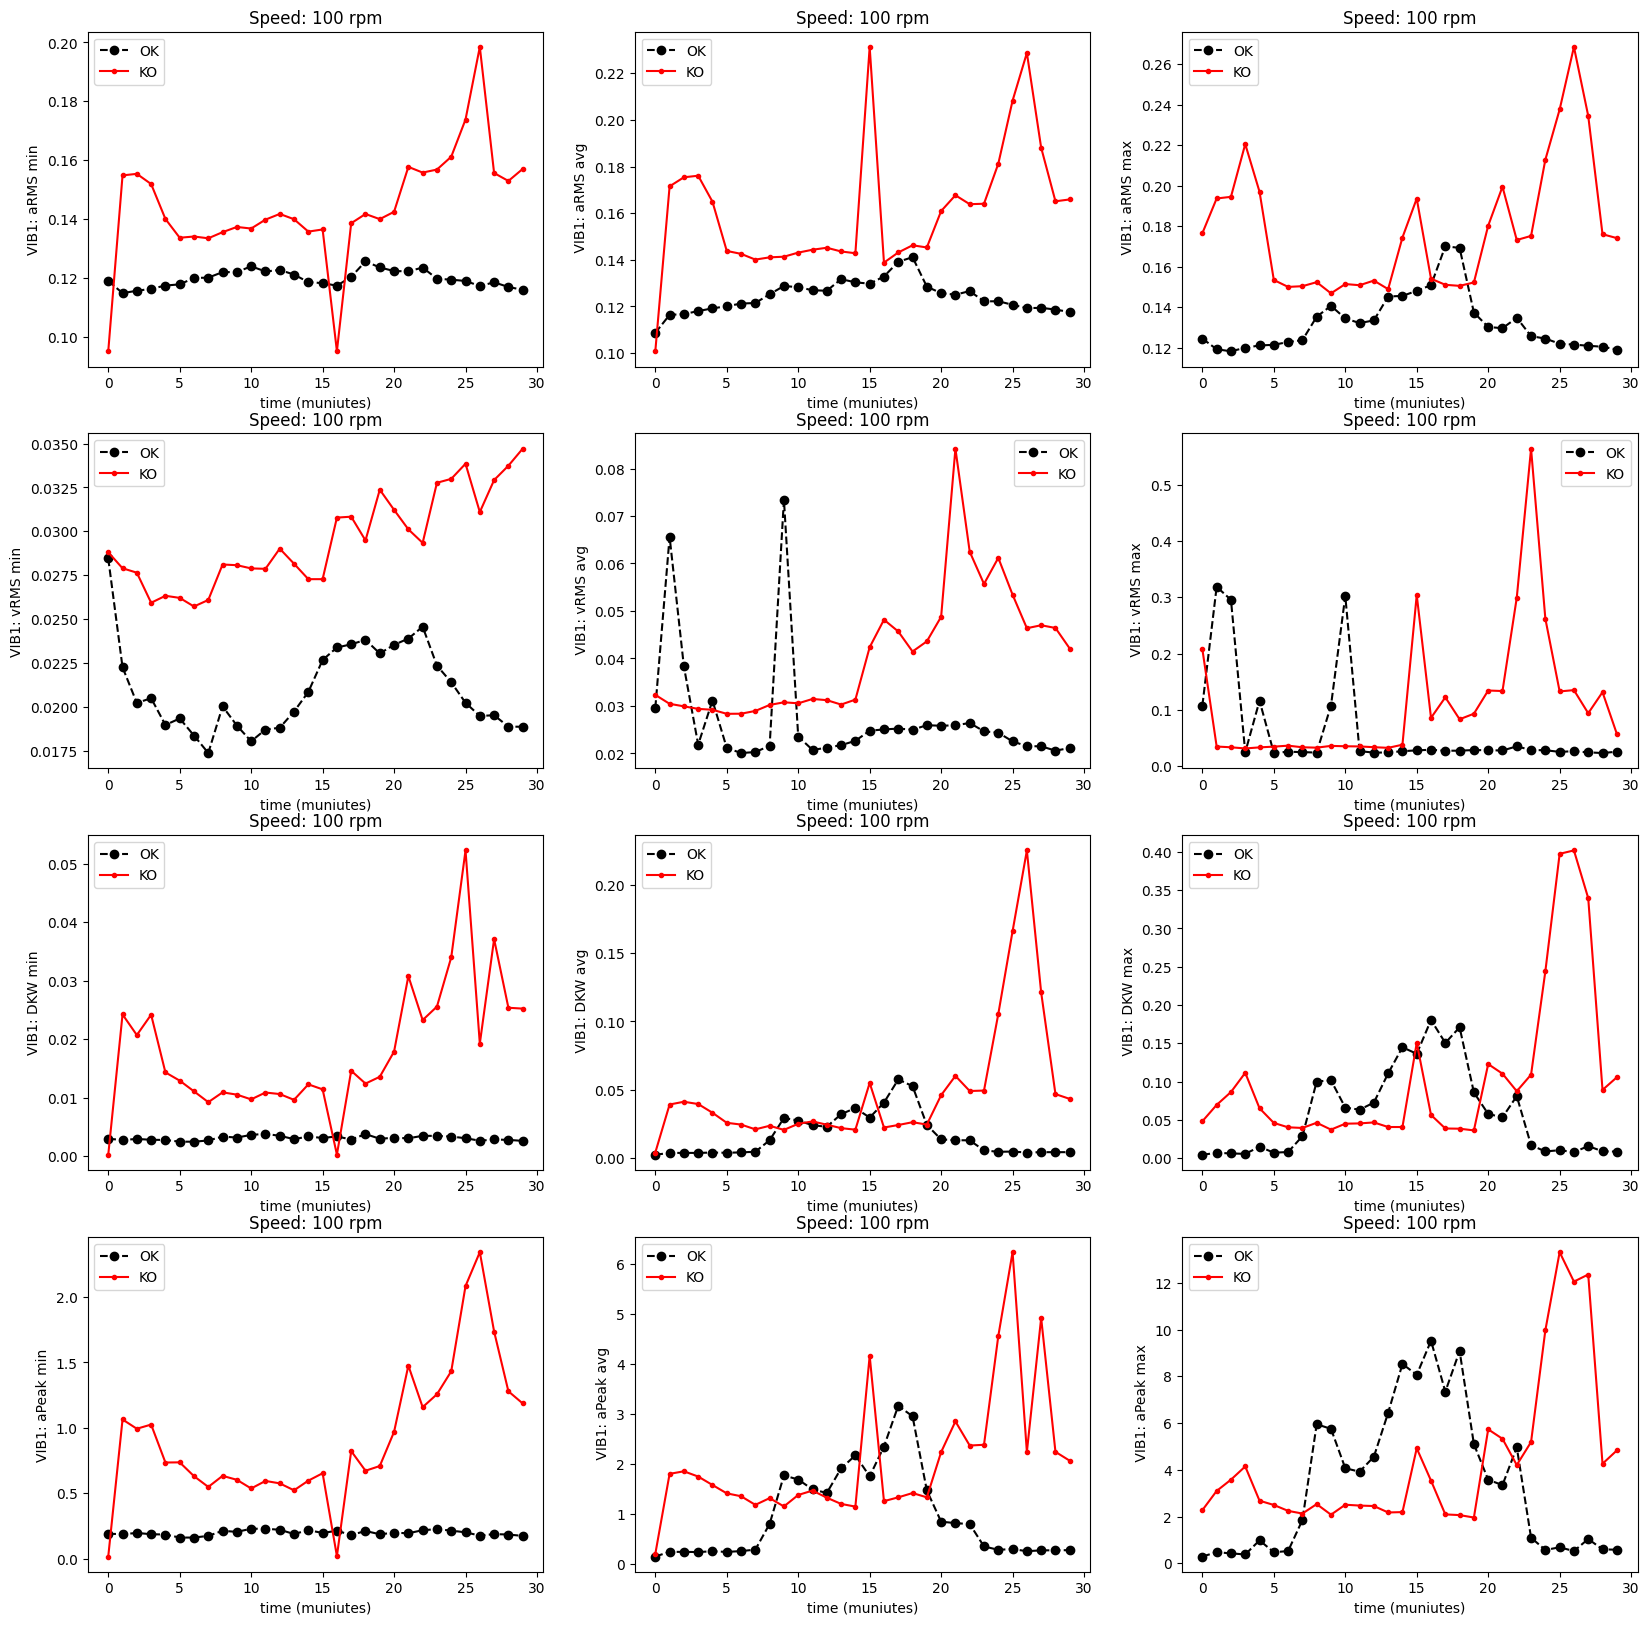

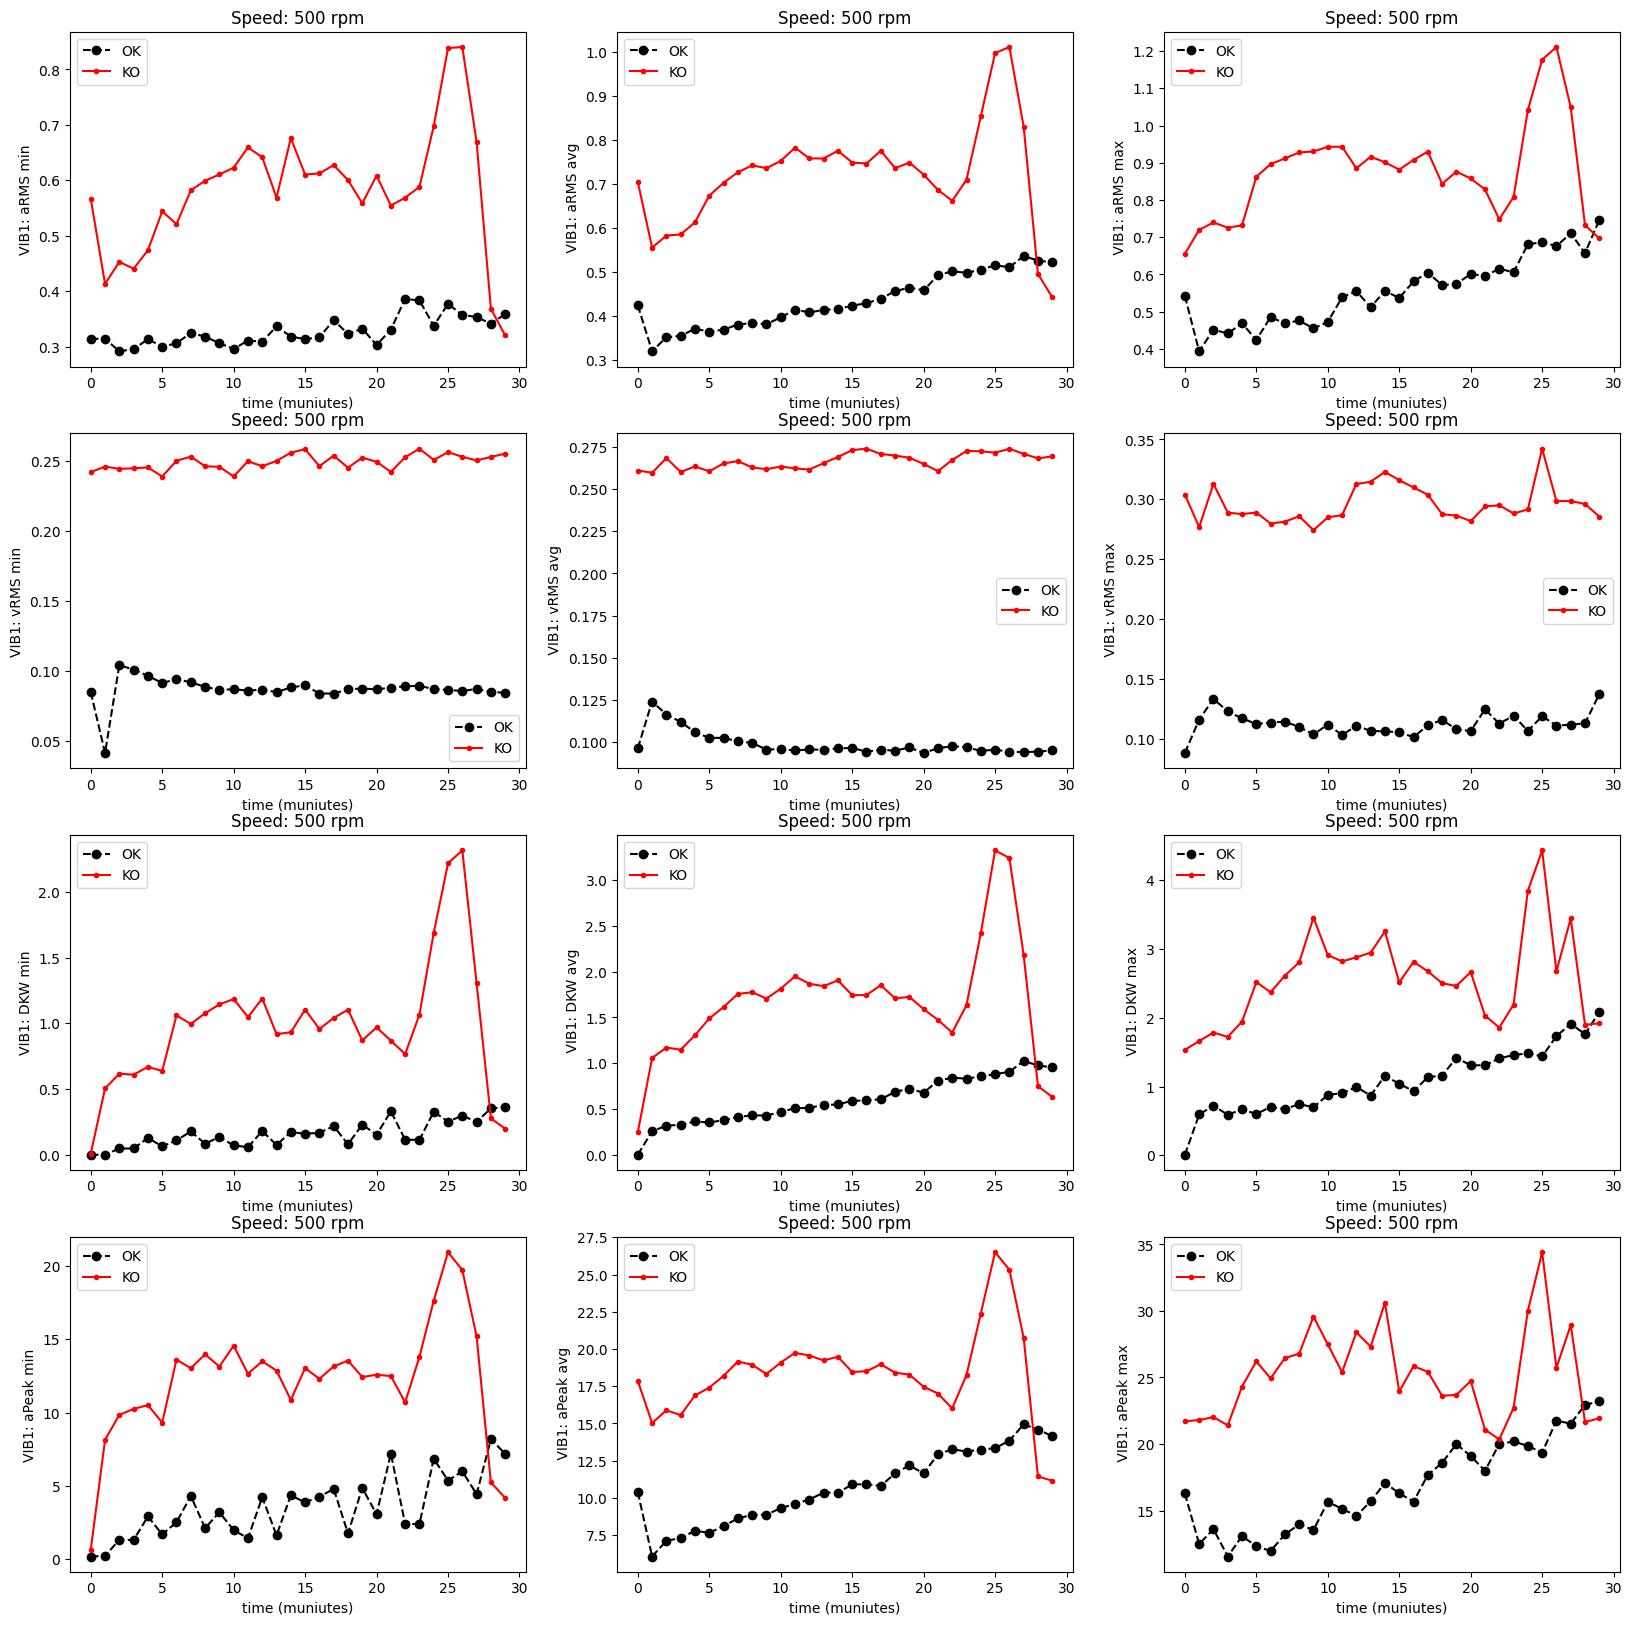

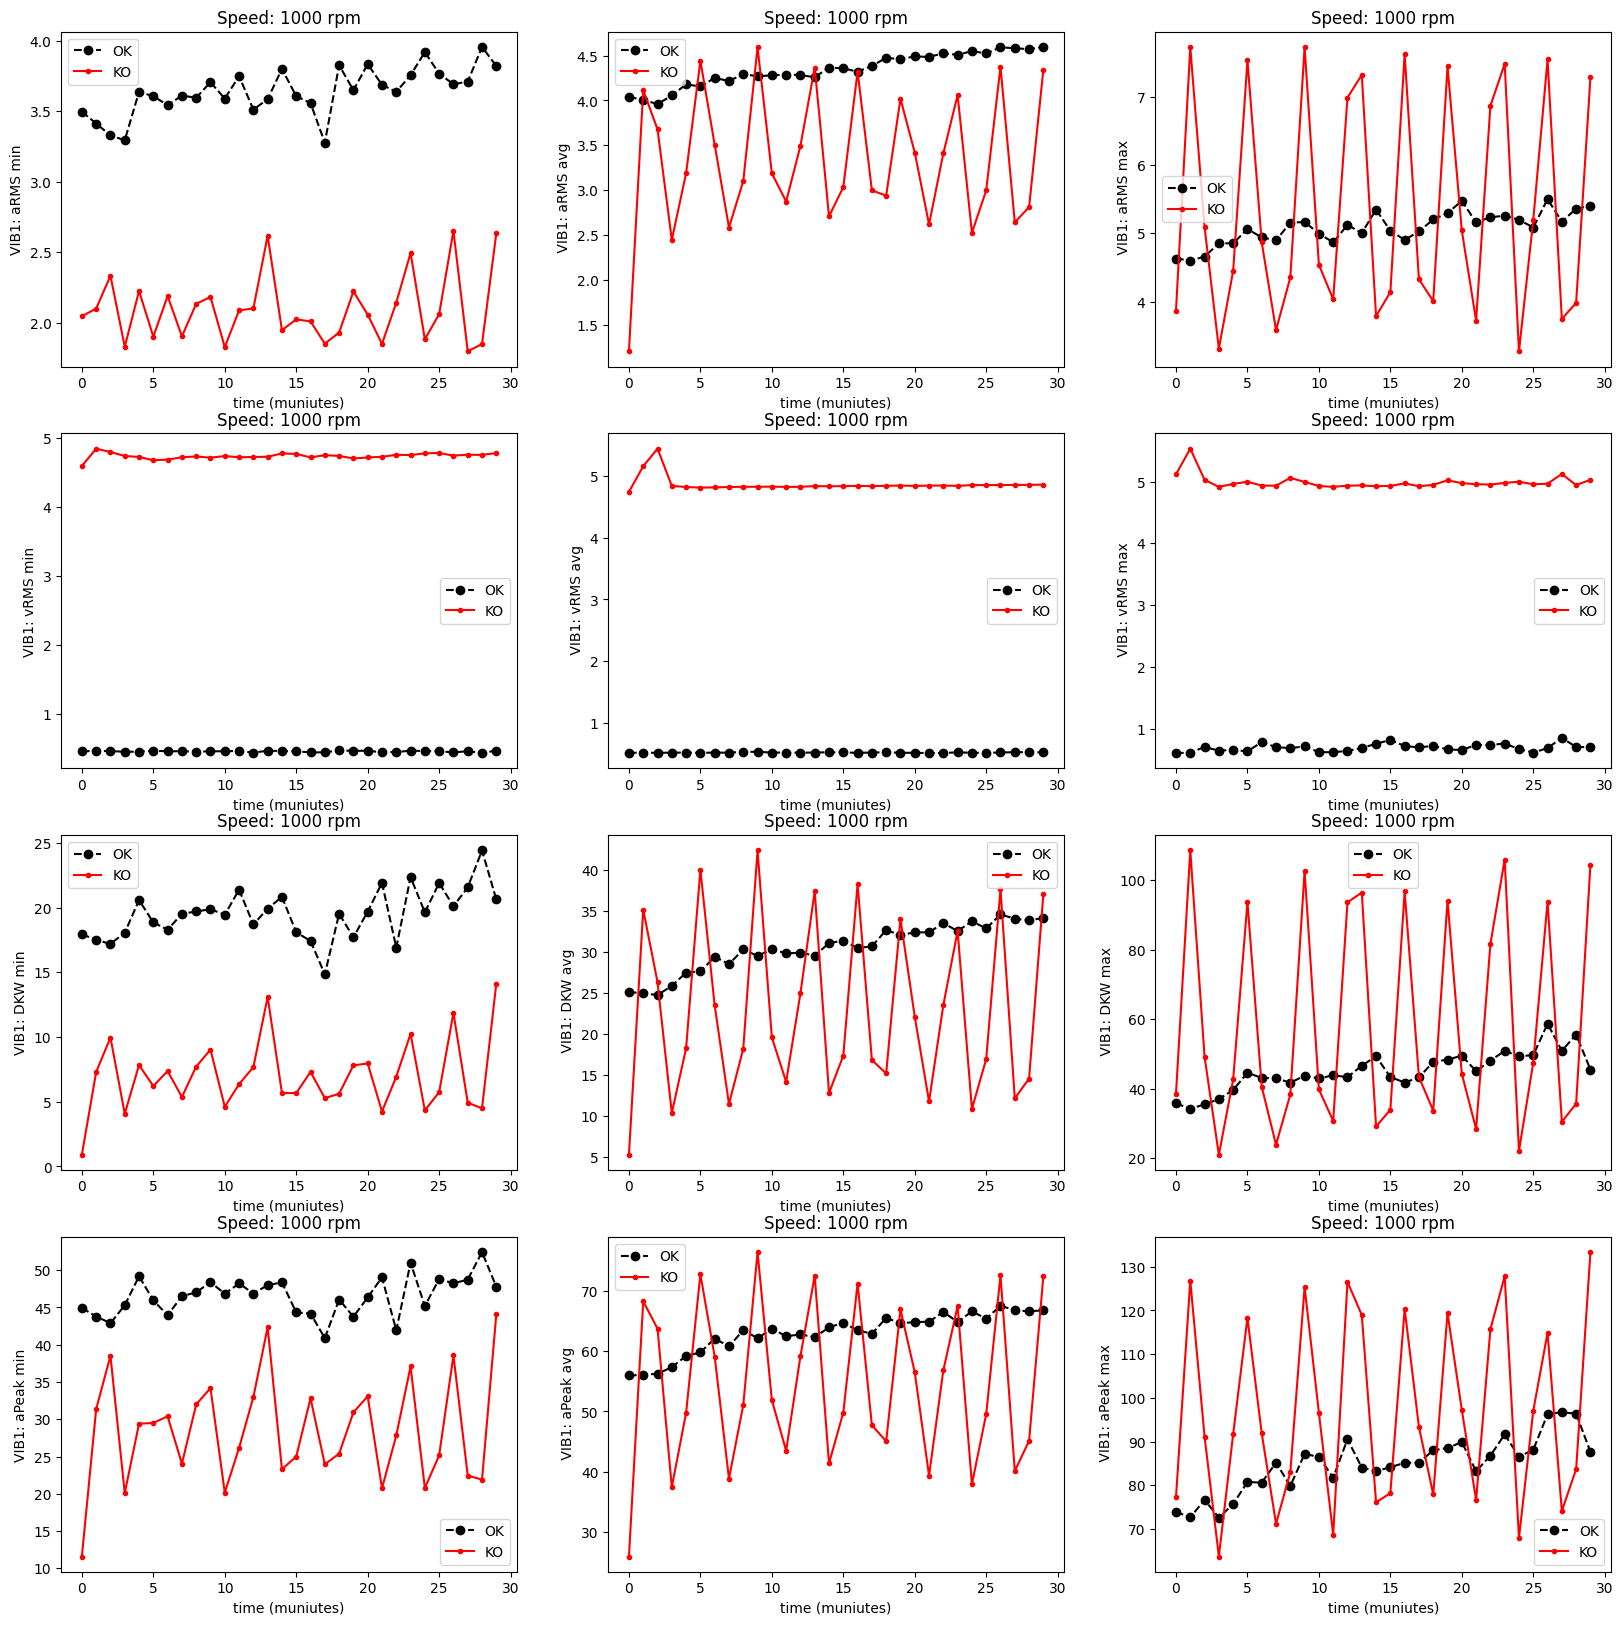

In [358]:
for speed in [100, 500, 1000]:
    fig, ax = plt.subplots(4, 3, figsize=(20, 20))
    i, j = 0, 0
    for feature in df_data_org.columns[:12]:
        ax[i,j].plot(np.arange(30), X[(df_data_org['Label']==0) & (df_data_org['Speed']==speed)][feature], '--ko', 
            np.arange(30), X[(df_data_org['Label']==1) & (df_data_org['Speed']==speed)][feature], '-r.')
        ax[i,j].set_xlabel('time (muniutes)')
        ax[i,j].set_ylabel(feature)
        ax[i,j].set_title('Speed: {} rpm'.format(speed))
        ax[i,j].legend(['OK', 'KO'])

        j+=1
        if j==3:
            i+=1
            j=0

## Scaling of the numerical features.

Define your strategy to scale the numerical features.

Reference: https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling

In [359]:
from sklearn import preprocessing

# Get the features and the labels.
Speed = df_data['Speed'].copy(deep= True)
X = df_data.drop(['Label'], axis=1)
Speed_encoded = pd.get_dummies(Speed, drop_first=True)
y = df_data['Label']
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = pd.DataFrame(data=scaler.transform(X), columns=X.columns)
X = pd.concat([X, Speed_encoded], axis=1)
X = X.rename(columns={500:'500', 1000:'1000'})
X

,VIB1: aRMS min,VIB1: aRMS avg,VIB1: aRMS max,VIB1: vRMS min,VIB1: vRMS avg,VIB1: vRMS max,VIB1: DKW min,VIB1: DKW avg,VIB1: DKW max,VIB1: aPeak min,VIB1: aPeak avg,VIB1: aPeak max,Speed,500,1000
0,-0.789312,-0.825551,-0.804636,-0.527634,-0.536658,-0.526689,-0.636545,-0.697604,-0.651478,-0.869620,-0.974956,-0.981062,-1.176965,0,0
1,-0.792483,-0.821033,-0.806857,-0.531264,-0.516094,-0.408313,-0.636576,-0.697501,-0.651386,-0.869888,-0.971297,-0.976368,-1.176965,0,0
2,-0.791877,-0.820844,-0.807280,-0.532455,-0.531674,-0.421275,-0.636550,-0.697501,-0.651414,-0.869304,-0.971317,-0.977607,-1.176965,0,0
3,-0.791374,-0.820081,-0.806546,-0.532295,-0.541076,-0.573326,-0.636570,-0.697502,-0.651436,-0.869866,-0.971445,-0.978826,-1.176965,0,0
4,-0.790518,-0.819402,-0.806066,-0.533190,-0.535770,-0.521887,-0.636574,-0.697481,-0.651095,-0.870005,-0.970836,-0.963326,-1.176965,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.695186,0.865346,1.335899,2.252969,2.217693,2.197132,0.157213,0.580981,1.084267,0.567029,0.971004,1.497927,1.267500,0,1
176,1.147001,1.671434,2.326694,2.230819,2.218458,2.202291,1.004228,2.137124,2.776715,1.339217,1.880171,1.955192,1.267500,0,1
177,0.494055,0.656823,0.724210,2.238397,2.219131,2.290887,0.045612,0.219638,0.461887,0.411293,0.597925,0.910899,1.267500,0,1
178,0.533319,0.756177,0.823654,2.236775,2.219965,2.189299,-0.016568,0.401894,0.650744,0.379727,0.795161,1.155602,1.267500,0,1


## PCA to have a look at the data patterns.

   principal component 1  principal component 2  Label
0              -2.809869               0.111030      0
1              -2.777777               0.175360      0
2              -2.784371               0.160694      0
3              -2.819949               0.084062      0
4              -2.802102               0.110818      0
[0.79746856 0.15613313]


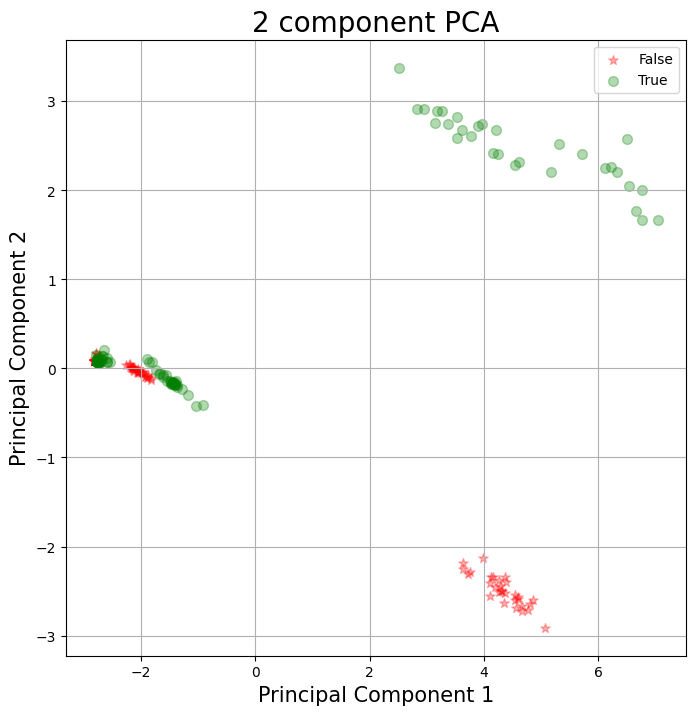

In [360]:
from utility import data_visualization_2d_pca

data_visualization_2d_pca(X, y, feature_list=X.columns)

# Feature selection

# Visual examination of the significance of the features.

A quick and easy way to examine if the features are relevant is to check $p(feature|label).$ If the conditional distribution of a feature changes a lot given positive/negative labels, we could suspect that it is a feature with significant impact. Otherwise, we might assume that this feature does not affect the result a lot.

For continuous features, we usually use volin plot. Here we show a demonstration how to construct a violin plot. You can try on the other continuous features to explore which features are highly significant. Please use it to determine the features you want to keep.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'VIB1: aRMS min'),
  Text(1, 0, ' VIB1: aRMS avg'),
  Text(2, 0, ' VIB1: aRMS max'),
  Text(3, 0, 'VIB1: vRMS min'),
  Text(4, 0, ' VIB1: vRMS avg'),
  Text(5, 0, ' VIB1: vRMS max')])

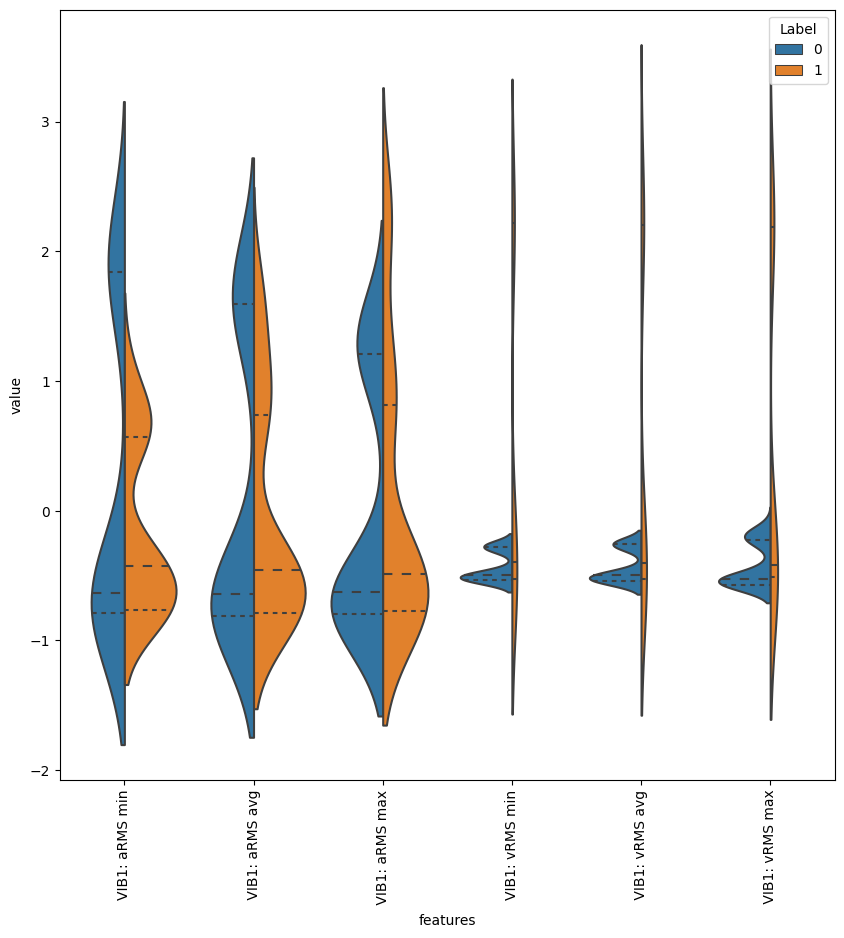

In [361]:
# first ten features
x = X.iloc[:, :6]

data = pd.concat([y, x], axis=1)
data = pd.melt(data,id_vars='Label',
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue='Label', data=data, split=True, inner="quart")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'VIB1: DKW min'),
  Text(1, 0, ' VIB1: DKW avg'),
  Text(2, 0, ' VIB1: DKW max'),
  Text(3, 0, 'VIB1: aPeak min'),
  Text(4, 0, ' VIB1: aPeak avg'),
  Text(5, 0, ' VIB1: aPeak max'),
  Text(6, 0, 'Speed')])

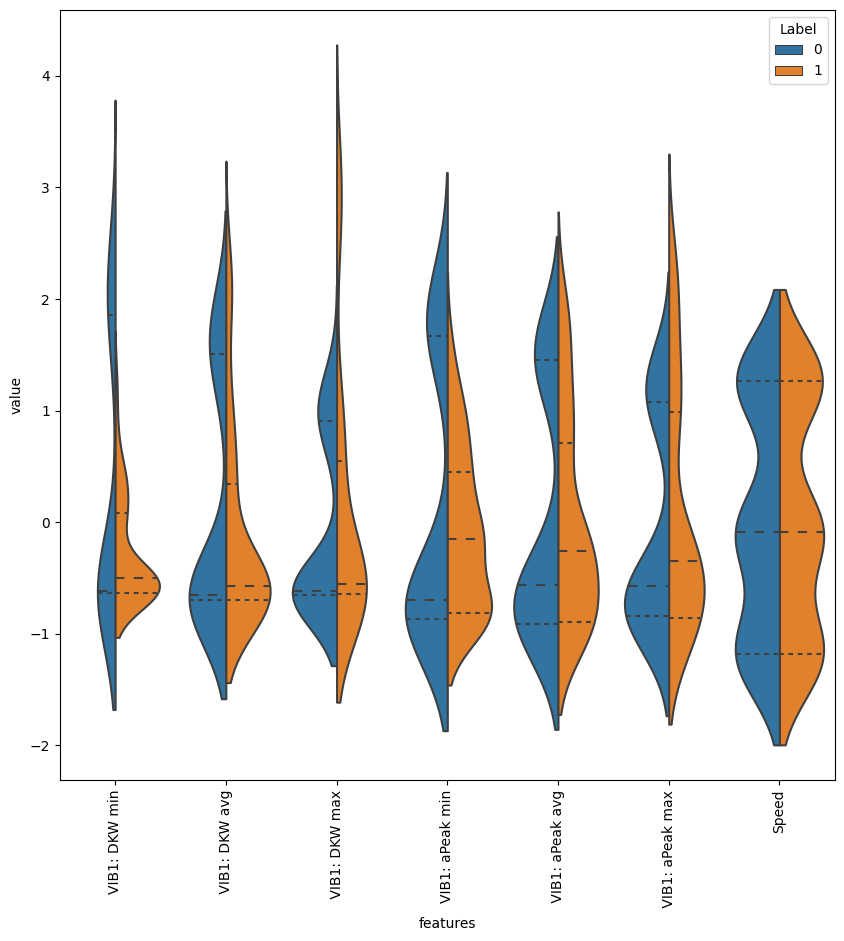

In [362]:
# first ten features
x = X.iloc[:, 6:13]

data = pd.concat([y, x], axis=1)
data = pd.melt(data,id_vars='Label',
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue='Label', data=data, split=True, inner="quart")
plt.xticks(rotation=90)

## Box plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'VIB1: aRMS min'),
  Text(1, 0, ' VIB1: aRMS avg'),
  Text(2, 0, ' VIB1: aRMS max'),
  Text(3, 0, 'VIB1: vRMS min'),
  Text(4, 0, ' VIB1: vRMS avg'),
  Text(5, 0, ' VIB1: vRMS max'),
  Text(6, 0, 'VIB1: DKW min'),
  Text(7, 0, ' VIB1: DKW avg'),
  Text(8, 0, ' VIB1: DKW max'),
  Text(9, 0, 'VIB1: aPeak min'),
  Text(10, 0, ' VIB1: aPeak avg'),
  Text(11, 0, ' VIB1: aPeak max'),
  Text(12, 0, 'Speed'),
  Text(13, 0, '500'),
  Text(14, 0, '1000')])

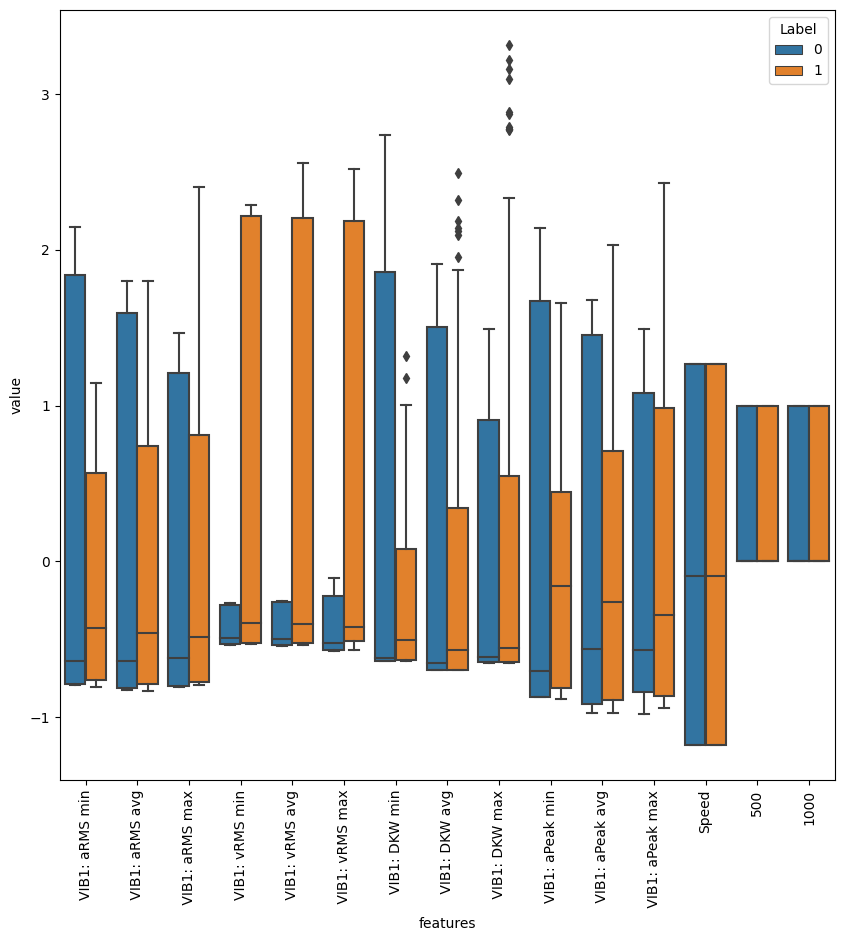

In [363]:
# 1st 10 features
data = pd.concat([y, X], axis=1)
data = pd.melt(data,id_vars='Label',
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="Label", data=data)
plt.xticks(rotation=90)

## Correlation matrix.

For the numerical features, you can also try to identify the relervant features using correlation matrix. The idea is to keep only the features highly correlated to the labels. Also, if two features are correlated, usually we only need to keep one of them.

Reference: https://www.kaggle.com/code/zhiguozeng/feature-selection-and-data-visualization

<AxesSubplot: >

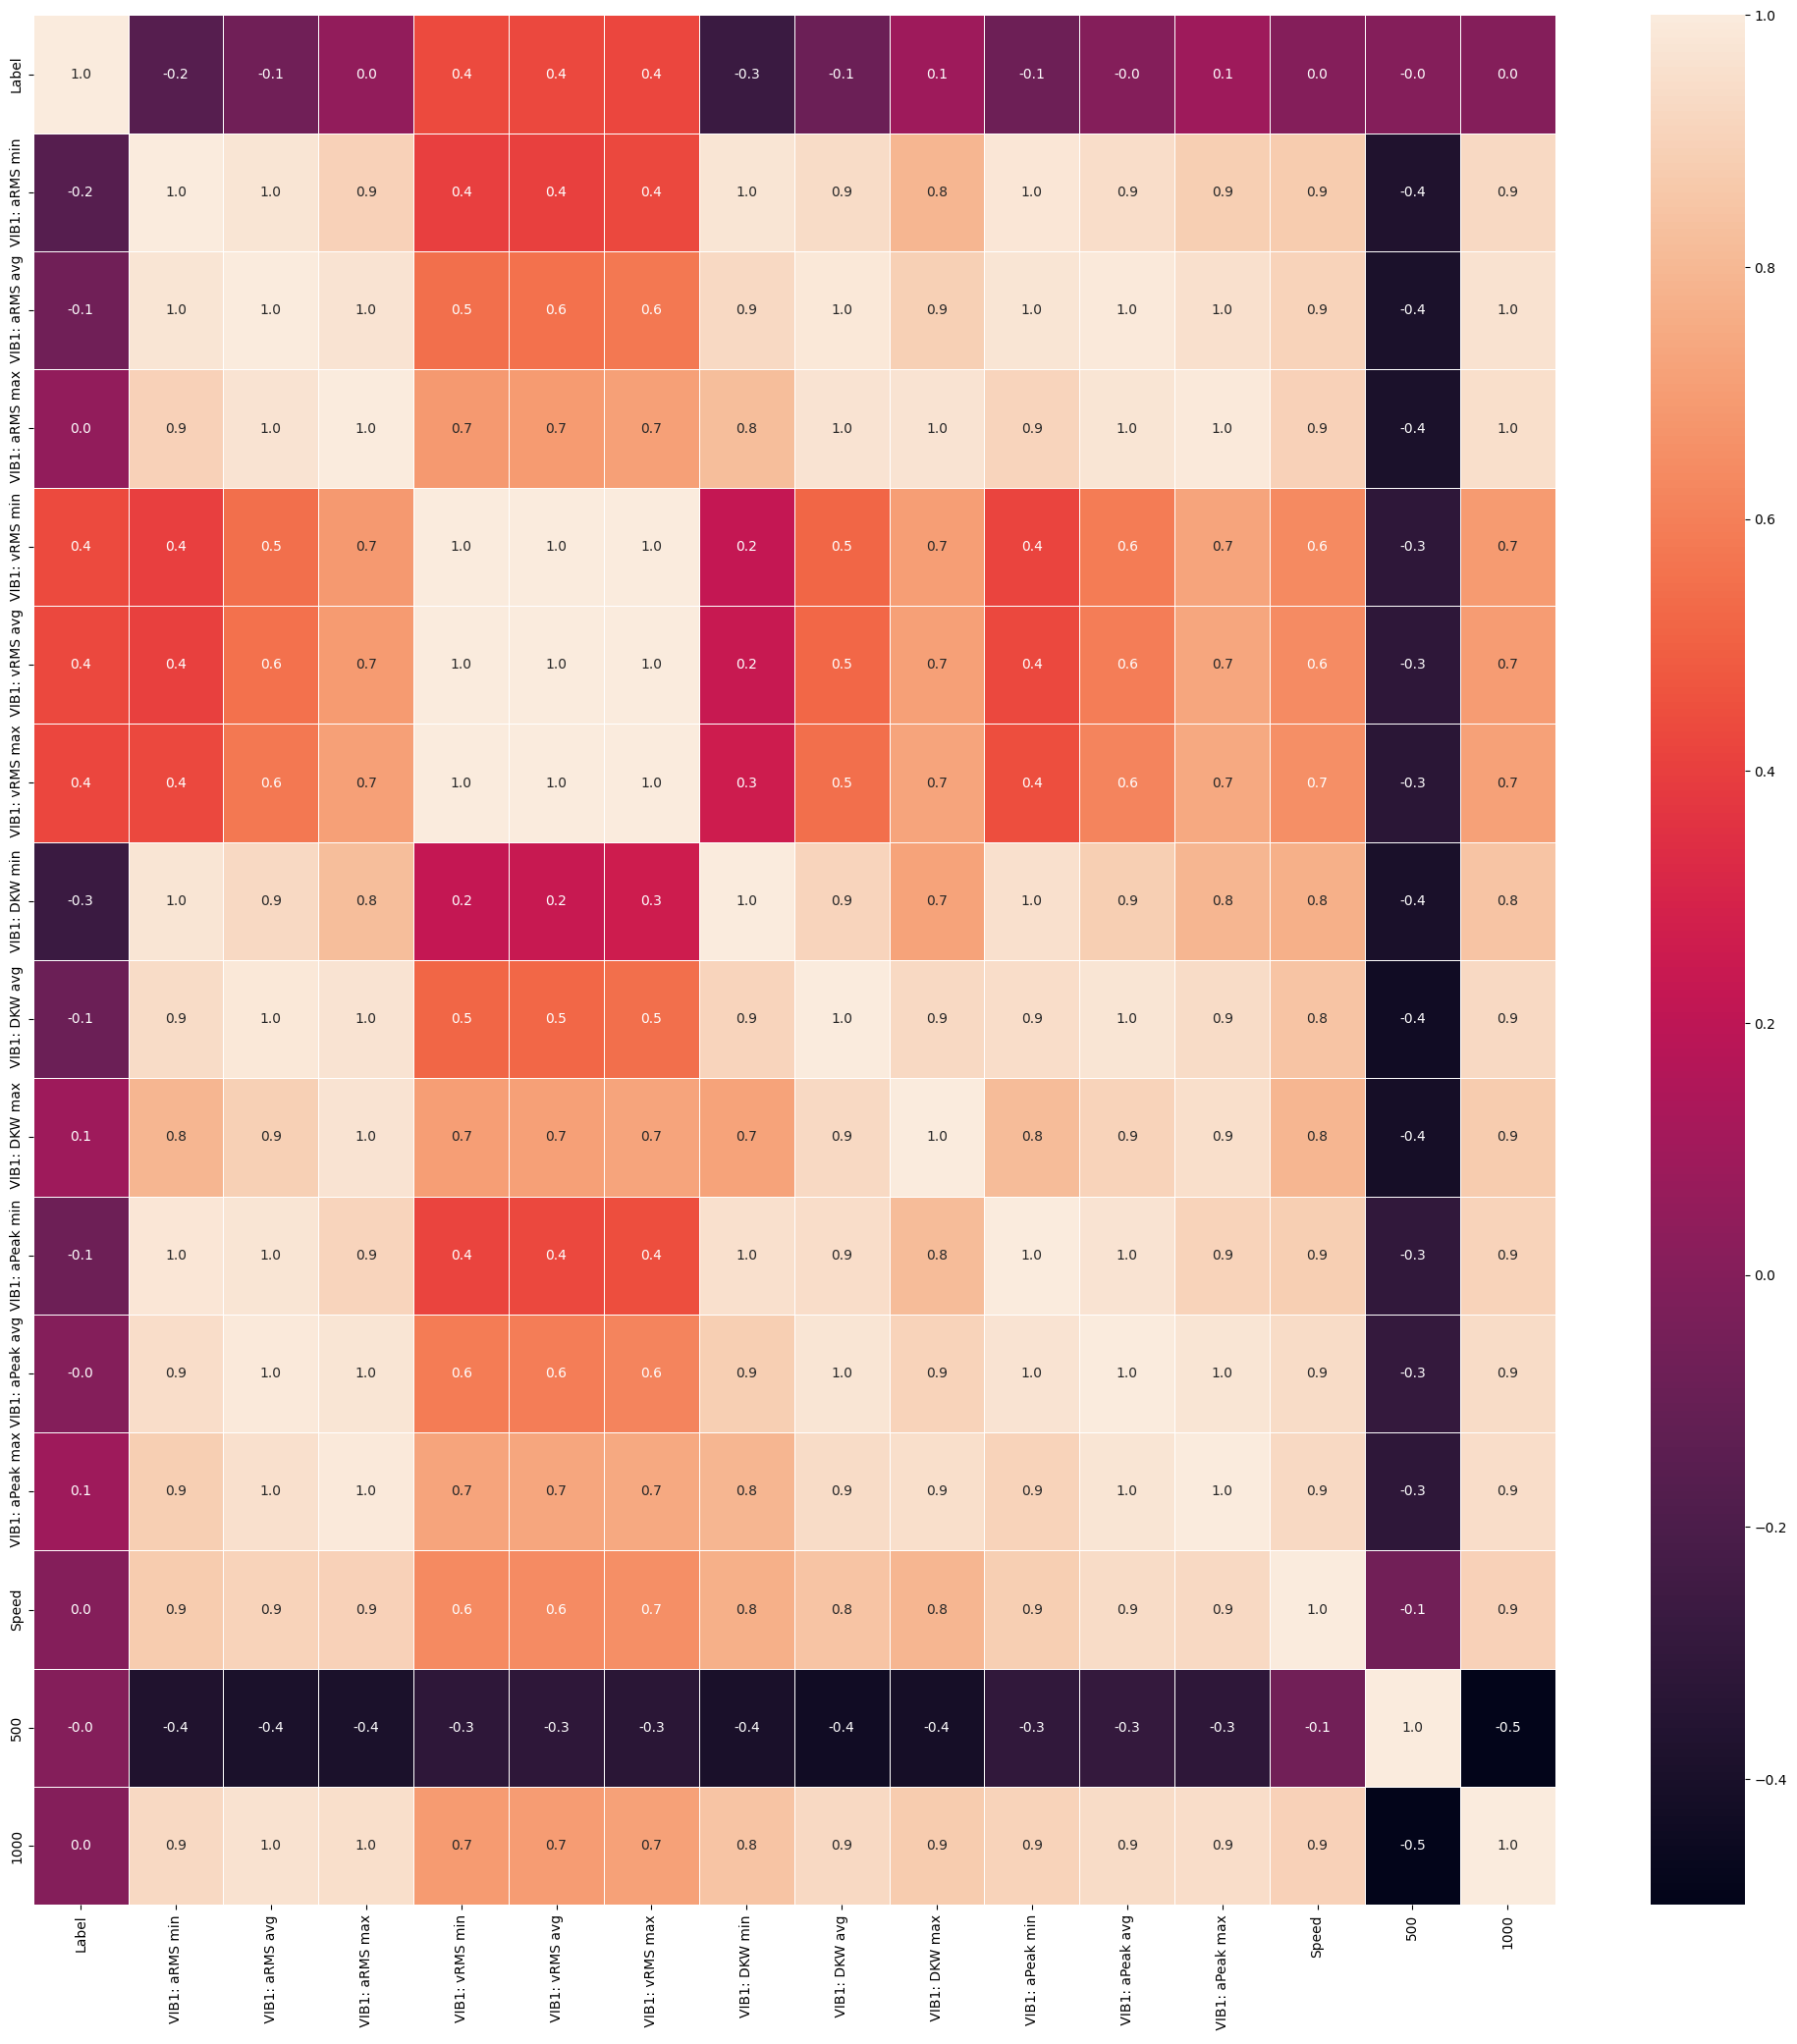

In [364]:
# correlation map
data = pd.concat([y, X], axis=1)
f,ax = plt.subplots(figsize=(25, 25))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Once you decide what are the relervant features, you can try the following code to verify your choice of the features by checking the performance of a Logistic regression model. We start with a simple classifier of logistic regression. Note that in the sample code, we only use the numerical feature. If you encode the categorical features, you should use all the features by replacing df_con to your new dataframe.

In [365]:
X_backup = X.copy(deep=True)
X_backup

,VIB1: aRMS min,VIB1: aRMS avg,VIB1: aRMS max,VIB1: vRMS min,VIB1: vRMS avg,VIB1: vRMS max,VIB1: DKW min,VIB1: DKW avg,VIB1: DKW max,VIB1: aPeak min,VIB1: aPeak avg,VIB1: aPeak max,Speed,500,1000
0,-0.789312,-0.825551,-0.804636,-0.527634,-0.536658,-0.526689,-0.636545,-0.697604,-0.651478,-0.869620,-0.974956,-0.981062,-1.176965,0,0
1,-0.792483,-0.821033,-0.806857,-0.531264,-0.516094,-0.408313,-0.636576,-0.697501,-0.651386,-0.869888,-0.971297,-0.976368,-1.176965,0,0
2,-0.791877,-0.820844,-0.807280,-0.532455,-0.531674,-0.421275,-0.636550,-0.697501,-0.651414,-0.869304,-0.971317,-0.977607,-1.176965,0,0
3,-0.791374,-0.820081,-0.806546,-0.532295,-0.541076,-0.573326,-0.636570,-0.697502,-0.651436,-0.869866,-0.971445,-0.978826,-1.176965,0,0
4,-0.790518,-0.819402,-0.806066,-0.533190,-0.535770,-0.521887,-0.636574,-0.697481,-0.651095,-0.870005,-0.970836,-0.963326,-1.176965,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.695186,0.865346,1.335899,2.252969,2.217693,2.197132,0.157213,0.580981,1.084267,0.567029,0.971004,1.497927,1.267500,0,1
176,1.147001,1.671434,2.326694,2.230819,2.218458,2.202291,1.004228,2.137124,2.776715,1.339217,1.880171,1.955192,1.267500,0,1
177,0.494055,0.656823,0.724210,2.238397,2.219131,2.290887,0.045612,0.219638,0.461887,0.411293,0.597925,0.910899,1.267500,0,1
178,0.533319,0.756177,0.823654,2.236775,2.219965,2.189299,-0.016568,0.401894,0.650744,0.379727,0.795161,1.155602,1.267500,0,1


In [366]:
# features = {1:'VIB1: aRMS min',2:'VIB1: aRMS avg',3:'VIB1: aRMS max',
#             4:'VIB1: vRMS min',5:'VIB1: vRMS avg',6:'VIB1: vRMS max',
#             7:'VIB1: DKW min',8:'VIB1: DKW avg',9:'VIB1: DKW max',
#             10:'VIB1: aPeak min',11:'VIB1: aPeak avg',12:'VIB1: aPeak max',13:'Speed'}

In [367]:
X_backup.columns

Index(['VIB1: aRMS min', ' VIB1: aRMS avg', ' VIB1: aRMS max',
       'VIB1: vRMS min', ' VIB1: vRMS avg', ' VIB1: vRMS max', 'VIB1: DKW min',
       ' VIB1: DKW avg', ' VIB1: DKW max', 'VIB1: aPeak min',
       ' VIB1: aPeak avg', ' VIB1: aPeak max', 'Speed', '500', '1000'],
      dtype='object')

In [368]:
X = X_backup.copy(deep=True)
# features_to_keep = [features[i] for i in id_to_keep]
# X = X_temp.iloc[:,id_to_keep]
X

,VIB1: aRMS min,VIB1: aRMS avg,VIB1: aRMS max,VIB1: vRMS min,VIB1: vRMS avg,VIB1: vRMS max,VIB1: DKW min,VIB1: DKW avg,VIB1: DKW max,VIB1: aPeak min,VIB1: aPeak avg,VIB1: aPeak max,Speed,500,1000
0,-0.789312,-0.825551,-0.804636,-0.527634,-0.536658,-0.526689,-0.636545,-0.697604,-0.651478,-0.869620,-0.974956,-0.981062,-1.176965,0,0
1,-0.792483,-0.821033,-0.806857,-0.531264,-0.516094,-0.408313,-0.636576,-0.697501,-0.651386,-0.869888,-0.971297,-0.976368,-1.176965,0,0
2,-0.791877,-0.820844,-0.807280,-0.532455,-0.531674,-0.421275,-0.636550,-0.697501,-0.651414,-0.869304,-0.971317,-0.977607,-1.176965,0,0
3,-0.791374,-0.820081,-0.806546,-0.532295,-0.541076,-0.573326,-0.636570,-0.697502,-0.651436,-0.869866,-0.971445,-0.978826,-1.176965,0,0
4,-0.790518,-0.819402,-0.806066,-0.533190,-0.535770,-0.521887,-0.636574,-0.697481,-0.651095,-0.870005,-0.970836,-0.963326,-1.176965,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.695186,0.865346,1.335899,2.252969,2.217693,2.197132,0.157213,0.580981,1.084267,0.567029,0.971004,1.497927,1.267500,0,1
176,1.147001,1.671434,2.326694,2.230819,2.218458,2.202291,1.004228,2.137124,2.776715,1.339217,1.880171,1.955192,1.267500,0,1
177,0.494055,0.656823,0.724210,2.238397,2.219131,2.290887,0.045612,0.219638,0.461887,0.411293,0.597925,0.910899,1.267500,0,1
178,0.533319,0.756177,0.823654,2.236775,2.219965,2.189299,-0.016568,0.401894,0.650744,0.379727,0.795161,1.155602,1.267500,0,1


In [369]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# split data train 70 % and test 30 %
x_train_backup, x_test_backup, y_train, y_test = train_test_split(X, y, test_size=0.3)



# Final output of workpackage 1

You should decide which features you are going to use, so that the performance using a simple logistic regression model can be the best. Apart from the visual inspection, you can also try some quantitative models, like the ones in https://www.kaggle.com/code/zhiguozeng/feature-selection-and-data-visualization.

In [370]:
id_to_keep = [0,1,2,3,4,5,6,7,8,9,10,11,13,14]

Accuracy is:  0.8333333333333334
Recall is:  0.8076923076923077
Precision is:  0.84
F1 is:  0.8235294117647058


<AxesSubplot: >

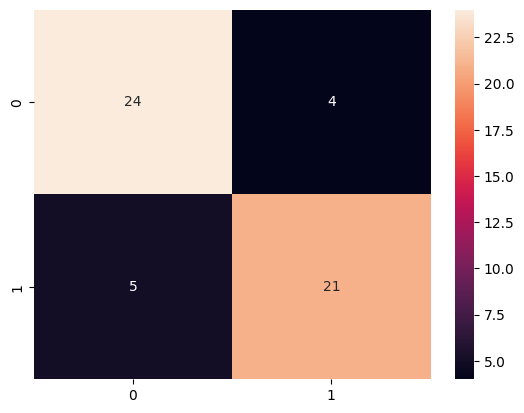

In [371]:
# id_to_keep = [0,3,4,5,7,9,10,13,14]
x_train = x_train_backup.iloc[:, id_to_keep]
x_test = x_test_backup.iloc[:, id_to_keep]

# Logistic regression
clf = LogisticRegression(penalty='l2', C=1)      
clr = clf.fit(x_train,y_train)

ac = accuracy_score(y_test, clf.predict(x_test))
print('Accuracy is: ',ac)
recall = recall_score(y_test, clf.predict(x_test))
print('Recall is: ',recall)
precision = precision_score(y_test, clf.predict(x_test))
print('Precision is: ', precision)
f1 = f1_score(y_test, clf.predict(x_test))
print('F1 is: ',f1)

cm = confusion_matrix(y_test, clf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

# Summary of preprocessing

## What if speed is missing

Accuracy is:  1.0


<AxesSubplot: >

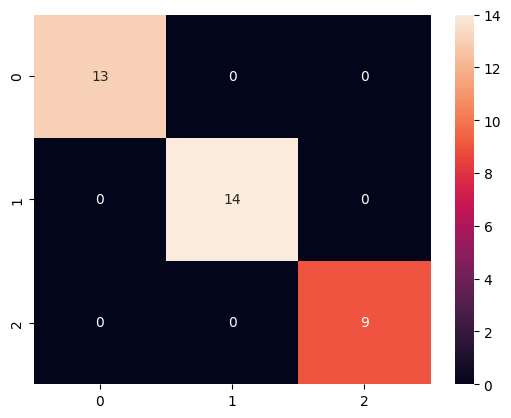

In [372]:
X = X_backup.copy(deep=True).iloc[:,:12]
X_train, X_test, Speed_train, Speed_test = train_test_split(X, Speed, test_size=0.2, random_state=42)
Speed_clf_1 = LogisticRegression()

Speed_clf_1 = LogisticRegression(penalty='l2', C=1)
Speed_clf_1 = Speed_clf_1.fit(X_train,Speed_train)
Speed_pred = Speed_clf_1.predict(X_test)
ac = accuracy_score(Speed_test, Speed_pred)
print('Accuracy is: ',ac)
# recall = recall_score(Speed_test, Speed_pred)
# print('Recall is: ',recall)
# precision = precision_score(Speed_test, Speed_pred)
# print('Precision is: ', precision)
# f1 = f1_score(Speed_test, Speed_pred)
# print('F1 is: ',f1)

cm = confusion_matrix(Speed_test, Speed_pred)
sns.heatmap(cm,annot=True,fmt="d")

In [373]:
final_Speed_clf_1 = LogisticRegression()
final_Speed_clf_1 = LogisticRegression(penalty='l2', C=1)      
final_Speed_clf_1 = final_Speed_clf_1.fit(X,Speed)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:  {'bootstrap': True, 'max_depth': None, 'n_estimators': 100}
Best score:  1.0
Accuracy is:  1.0


<AxesSubplot: >

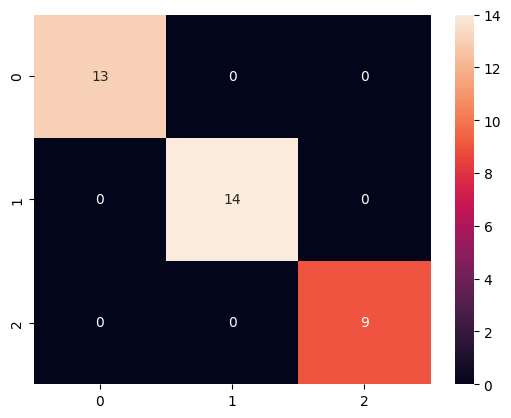

In [374]:
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
parameters = {"n_estimators": [10, 50, 100],
              "bootstrap":[True, False],
              "max_depth":[None, 10, 20,50]}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
Speed_clf_2 = GridSearchCV(RandomForestClassifier(),
                   param_grid=parameters,
                   cv=kf,
                   refit=True,
                   verbose = 1)
Speed_clf_2.fit(X_train,Speed_train)
print("Best parameters: ", Speed_clf_2.best_params_)
print("Best score: ", Speed_clf_2.best_score_)
Speed_pred = Speed_clf_2.predict(X_test)
ac = accuracy_score(Speed_test, Speed_pred)
print('Accuracy is: ',ac)
# recall = recall_score(Speed_test, Speed_pred)
# print('Recall is: ',recall)
# precision = precision_score(Speed_test, Speed_pred)
# print('Precision is: ', precision)
# f1 = f1_score(Speed_test, Speed_pred)
# print('F1 is: ',f1)

cm = confusion_matrix(Speed_test, Speed_pred)
sns.heatmap(cm,annot=True,fmt="d")

In [375]:
params = Speed_clf_2.best_params_
# params_save =  {'bootstrap': False, 'max_depth': 10, 'n_estimators': 10}
final_Speed_clf_2= RandomForestClassifier(**params)
final_Speed_clf_2.fit(X,Speed)

RandomForestClassifier()

In [376]:
def preprocess(data, scaler, X, id_to_keep, speed_missing=False, return_speed=False):
    if data.isnull().values.any():
        print('null values detected')
    X_test = data.copy(deep=True)
    if speed_missing :
        X_test['Speed'] = 0
        X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)
        Speed = final_Speed_clf_2.predict(X_test.drop(['Speed'],axis=1))
        Speed_encoded = pd.get_dummies(Speed, drop_first=True)
    else :
        Speed = X_test['Speed']
        Speed_encoded = pd.get_dummies(Speed, drop_first=True)
        X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

    X_test = pd.concat([X_test, Speed_encoded], axis=1)
    X_test = X_test.rename(columns={500:'500', 1000:'1000'})
    missing_cols = set(X.columns) - set(X_test.columns)
    for c in missing_cols:
        X_test[c] = 0
    X_test = X_test[X.columns]
    print(X_test.columns)
    X_test = X_test.iloc[:, id_to_keep]
    if return_speed :
        return X_test, Speed
    return X_test

# Work package 2

In WP1, you already clean the data, and select the most relevant features. In this work package, the purpose is to develop a machine learning to detect the failed bearing with best performance. 
* Task 1: Design an experiment scheme which evaluates the performance of the developed model based on cross validation.
* Task 2: Develop a model to achieve the best failure detection performance on an individual measurement.
* Task 3: Develop a model to achieve the best failure detection performance on time-series data under variate working conditions.

In this section, you need to present the following (with code and texts to explain):
1. Model selection: Report all the models you have tried on the training dataset and evaluate their performance using cross validation.
2. Data challenge: Apply the best model in the testing dataset:
    * Test bearing 1&2:
        * Explain how do you apply your model to deal with the time-series problem.
        * Apply the model to predict the labels at each time instants.
    * Test bearing 3&4:
        * Explain how do you apply your model to solve the problem of missing the speed measurement.
        * Apply the model to predict the labels at each time instants.
    * Save the results of the predictions in the givne excel file.

In [377]:
clf = GridSearchCV(RandomForestClassifier(),
                   param_grid=parameters,
                   cv=kf,
                   refit=True,
                   verbose = 1)
X = X_backup.copy(deep=True)
X = X.iloc[:, id_to_keep]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train,y_train)
print("Best parameters: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:  {'bootstrap': False, 'max_depth': None, 'n_estimators': 10}
Best score:  0.993103448275862


accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0


<AxesSubplot: >

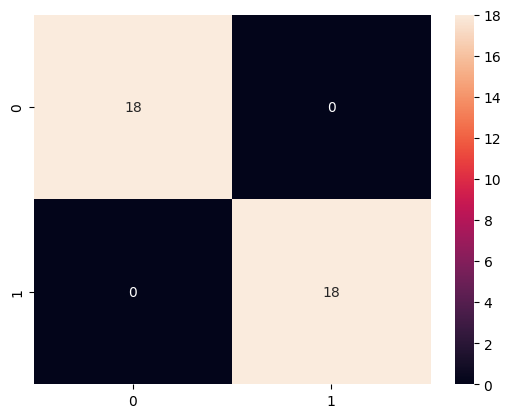

In [378]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("accuracy :", accuracy)
print("precision :", precision)
print("recall :", recall)
print("f1 :", f1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d")


In [379]:
params = clf.best_params_
params_save =  {'bootstrap': False, 'max_depth': 10, 'n_estimators': 10}
clf_final = RandomForestClassifier(**params_save)
results = cross_validate(clf_final, X, y, cv=5, 
                         scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True)
cv_scores = {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
             }
print(cv_scores)
clf_final.fit(X,y)

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]), 'Mean Training Accuracy': 100.0, 'Training Precision scores': array([1., 1., 1., 1., 1.]), 'Mean Training Precision': 1.0, 'Training Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Training Recall': 1.0, 'Training F1 scores': array([1., 1., 1., 1., 1.]), 'Mean Training F1 Score': 1.0, 'Validation Accuracy scores': array([0.75      , 0.94444444, 1.        , 0.97222222, 0.97222222]), 'Mean Validation Accuracy': 92.77777777777779, 'Validation Precision scores': array([0.8       , 1.        , 1.        , 0.94736842, 1.        ]), 'Mean Validation Precision': 0.9494736842105261, 'Validation Recall scores': array([0.66666667, 0.88888889, 1.        , 1.        , 0.94444444]), 'Mean Validation Recall': 0.9, 'Validation F1 scores': array([0.72727273, 0.94117647, 1.        , 0.97297297, 0.97142857]), 'Mean Validation F1 Score': 0.9225701484525015}


RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=10)

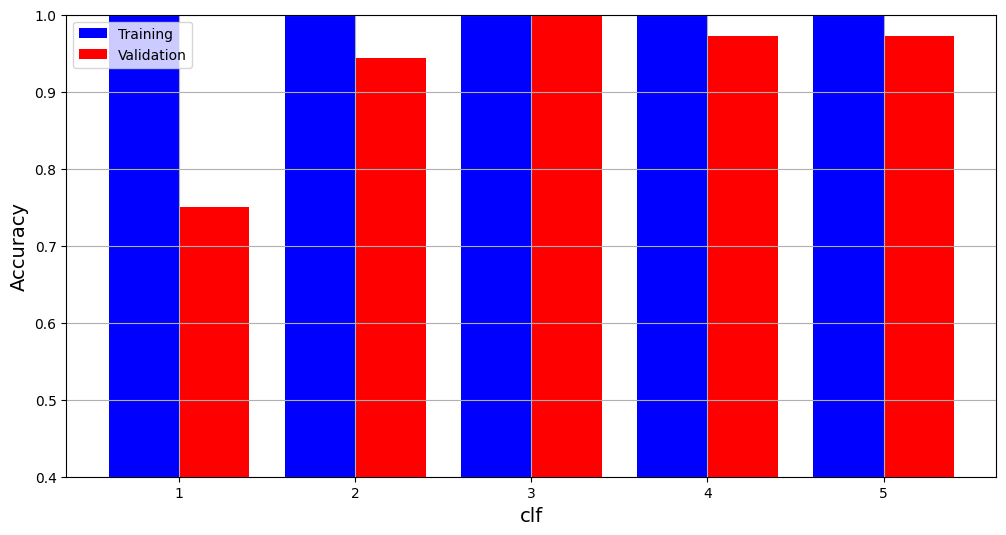

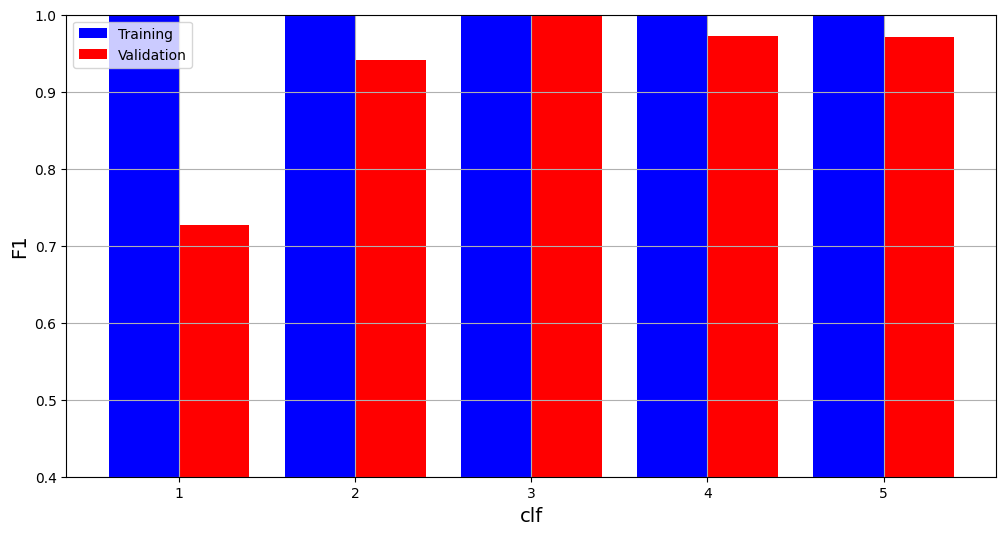

In [380]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = np.arange(len(train_data))+1
        X_axis = np.arange(len(train_data))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()


plot_result('clf',
            "Accuracy",
            "Accuracy scores in 5 Folds",
            cv_scores["Training Accuracy scores"],
            cv_scores["Validation Accuracy scores"])

plot_result('clf',
            "F1",
            "F1 scores in 5 Folds",
            cv_scores["Training F1 scores"],
            cv_scores["Validation F1 scores"])

In [419]:
def read_test_data(page):
    filename = 'Testing.xlsx'
    df = pd.read_excel(filename, sheet_name=page, usecols='A:M', header=0, nrows=20)
    return df

df_test_1 = read_test_data(1)
X_test_1 = preprocess(df_test_1, scaler, X_backup, id_to_keep)
X_test_1
clf_final.predict(X_test_1)


Index(['VIB1: aRMS min', ' VIB1: aRMS avg', ' VIB1: aRMS max',
       'VIB1: vRMS min', ' VIB1: vRMS avg', ' VIB1: vRMS max', 'VIB1: DKW min',
       ' VIB1: DKW avg', ' VIB1: DKW max', 'VIB1: aPeak min',
       ' VIB1: aPeak avg', ' VIB1: aPeak max', 'Speed', '500', '1000'],
      dtype='object')


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

In [425]:
df_test_2 = read_test_data(1)
X_test_2 = preprocess(df_test_2, scaler, X_backup, id_to_keep, speed_missing=True)
clf_final.predict(X_test_2)

Index(['VIB1: aRMS min', ' VIB1: aRMS avg', ' VIB1: aRMS max',
       'VIB1: vRMS min', ' VIB1: vRMS avg', ' VIB1: vRMS max', 'VIB1: DKW min',
       ' VIB1: DKW avg', ' VIB1: DKW max', 'VIB1: aPeak min',
       ' VIB1: aPeak avg', ' VIB1: aPeak max', 'Speed', '500', '1000'],
      dtype='object')


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int64)

## Using Information from past samples


In [409]:
X = X_backup.copy(deep=True)
X = X.iloc[:, id_to_keep]
X_shifted = X_backup.copy(deep=True)
shifted_id = [1,4,7,10,13,14]
X_shifted = X_shifted.iloc[:,shifted_id]

In [410]:
def shift_df(df):
    df_copy = df.copy(deep=True)
    df_shifted = df_copy.shift(1)
    df_shifted.iloc[0] = df_copy.iloc[0]
    return df_shifted

for speed in [100, 500, 1000]:
    for label in [0, 1]:    
        x = X_shifted.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed)]
        x = shift_df(x)
        X_shifted.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed)] = x

X_shifted.columns = [col + '_t-1' for col in X_shifted.columns]

In [411]:
X_final = pd.concat([X, X_shifted], axis=1)
X_final

,VIB1: aRMS min,VIB1: aRMS avg,VIB1: aRMS max,VIB1: vRMS min,VIB1: vRMS avg,VIB1: vRMS max,VIB1: DKW min,VIB1: DKW avg,VIB1: DKW max,VIB1: aPeak min,VIB1: aPeak avg,VIB1: aPeak max,500,1000,VIB1: aRMS avg_t-1,VIB1: vRMS avg_t-1,VIB1: DKW avg_t-1,VIB1: aPeak avg_t-1,500_t-1,1000_t-1
0,-0.789312,-0.825551,-0.804636,-0.527634,-0.536658,-0.526689,-0.636545,-0.697604,-0.651478,-0.869620,-0.974956,-0.981062,0,0,-0.825551,-0.536658,-0.697604,-0.974956,0,0
1,-0.792483,-0.821033,-0.806857,-0.531264,-0.516094,-0.408313,-0.636576,-0.697501,-0.651386,-0.869888,-0.971297,-0.976368,0,0,-0.825551,-0.536658,-0.697604,-0.974956,0,0
2,-0.791877,-0.820844,-0.807280,-0.532455,-0.531674,-0.421275,-0.636550,-0.697501,-0.651414,-0.869304,-0.971317,-0.977607,0,0,-0.821033,-0.516094,-0.697501,-0.971297,0,0
3,-0.791374,-0.820081,-0.806546,-0.532295,-0.541076,-0.573326,-0.636570,-0.697502,-0.651436,-0.869866,-0.971445,-0.978826,0,0,-0.820844,-0.531674,-0.697501,-0.971317,0,0
4,-0.790518,-0.819402,-0.806066,-0.533190,-0.535770,-0.521887,-0.636574,-0.697481,-0.651095,-0.870005,-0.970836,-0.963326,0,0,-0.820081,-0.541076,-0.697502,-0.971445,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.695186,0.865346,1.335899,2.252969,2.217693,2.197132,0.157213,0.580981,1.084267,0.567029,0.971004,1.497927,0,1,0.588394,2.217984,0.121900,0.511238,0,1
176,1.147001,1.671434,2.326694,2.230819,2.218458,2.202291,1.004228,2.137124,2.776715,1.339217,1.880171,1.955192,0,1,0.865346,2.217693,0.580981,0.971004,0,1
177,0.494055,0.656823,0.724210,2.238397,2.219131,2.290887,0.045612,0.219638,0.461887,0.411293,0.597925,0.910899,0,1,1.671434,2.218458,2.137124,1.880171,0,1
178,0.533319,0.756177,0.823654,2.236775,2.219965,2.189299,-0.016568,0.401894,0.650744,0.379727,0.795161,1.155602,0,1,0.656823,2.219131,0.219638,0.597925,0,1


In [412]:
clf_shift = GridSearchCV(RandomForestClassifier(),
                   param_grid=parameters,
                   cv=kf,
                   refit=True,
                   verbose = 1)

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
clf_shift.fit(X_train,y_train)
print("Best parameters: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:  {'bootstrap': False, 'max_depth': None, 'n_estimators': 10}
Best score:  0.993103448275862


accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0


<AxesSubplot: >

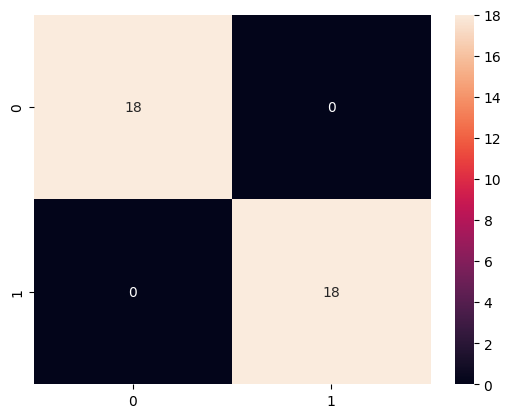

In [387]:
y_pred = clf_shift.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("accuracy :", accuracy)
print("precision :", precision)
print("recall :", recall)
print("f1 :", f1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d")

In [388]:
params_shift = clf_shift.best_params_
# params_save =  {'bootstrap': False, 'max_depth': 10, 'n_estimators': 10}
clf_shift_final = RandomForestClassifier(**params_shift)
clf_shift_final.fit(X_final,y)

RandomForestClassifier(max_depth=50, n_estimators=10)

In [406]:
def preprocess_shifted(df, scaler, X_backup, id_to_keep, shifted_id, speed_missing = False):
    X1 = preprocess(df, scaler, X_backup, id_to_keep, speed_missing = speed_missing)
    X1_shifted = preprocess(df, scaler, X_backup, shifted_id, speed_missing = speed_missing)
    X1_shifted = shift_df(X1_shifted)
    X1_shifted.columns = [col + '_t-1' for col in X1_shifted.columns]
    X1_final = pd.concat([X1, X1_shifted], axis=1)
    return X1_final

df_test_1 = read_test_data(1)
X_test_shifted_1 = preprocess_shifted(df_test_1, scaler,X_backup, id_to_keep, shifted_id, False)
clf_shift_final.predict(X_test_shifted_1)


Index(['VIB1: aRMS min', ' VIB1: aRMS avg', ' VIB1: aRMS max',
       'VIB1: vRMS min', ' VIB1: vRMS avg', ' VIB1: vRMS max', 'VIB1: DKW min',
       ' VIB1: DKW avg', ' VIB1: DKW max', 'VIB1: aPeak min',
       ' VIB1: aPeak avg', ' VIB1: aPeak max', 'Speed', '500', '1000'],
      dtype='object')
Index(['VIB1: aRMS min', ' VIB1: aRMS avg', ' VIB1: aRMS max',
       'VIB1: vRMS min', ' VIB1: vRMS avg', ' VIB1: vRMS max', 'VIB1: DKW min',
       ' VIB1: DKW avg', ' VIB1: DKW max', 'VIB1: aPeak min',
       ' VIB1: aPeak avg', ' VIB1: aPeak max', 'Speed', '500', '1000'],
      dtype='object')


array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1], dtype=int64)

In [408]:
df_test_2 = read_test_data(3)
X_test_shifted_2 = preprocess_shifted(df_test_2, scaler,X_backup,id_to_keep, shifted_id, True)
clf_shift_final.predict(X_test_shifted_2)

null values detected
Index(['VIB1: aRMS min', ' VIB1: aRMS avg', ' VIB1: aRMS max',
       'VIB1: vRMS min', ' VIB1: vRMS avg', ' VIB1: vRMS max', 'VIB1: DKW min',
       ' VIB1: DKW avg', ' VIB1: DKW max', 'VIB1: aPeak min',
       ' VIB1: aPeak avg', ' VIB1: aPeak max', 'Speed', '500', '1000'],
      dtype='object')
null values detected
Index(['VIB1: aRMS min', ' VIB1: aRMS avg', ' VIB1: aRMS max',
       'VIB1: vRMS min', ' VIB1: vRMS avg', ' VIB1: vRMS max', 'VIB1: DKW min',
       ' VIB1: DKW avg', ' VIB1: DKW max', 'VIB1: aPeak min',
       ' VIB1: aPeak avg', ' VIB1: aPeak max', 'Speed', '500', '1000'],
      dtype='object')


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

## A model for Each Speed

In [391]:
X = X_backup.copy(deep=True)
id_to_keep1 = [1,4,7,10]
X = X.iloc[:,id_to_keep1]
speeds = [100,500,1000]

In [392]:
X_dict={}
y_dict = {}
for speed in speeds:
    X_dict[speed] = X.loc[(df_data_org['Speed']==speed)].copy(deep=True)
    y_dict[speed] = y.loc[(df_data_org['Speed']==speed)].copy(deep=True)


In [393]:
ind = 100
print(X_dict[ind].shape)
X_dict[ind].head(10)

(60, 4)


,VIB1: aRMS avg,VIB1: vRMS avg,VIB1: DKW avg,VIB1: aPeak avg
0,-0.825551,-0.536658,-0.697604,-0.974956
1,-0.821033,-0.516094,-0.697501,-0.971297
2,-0.820844,-0.531674,-0.697501,-0.971317
3,-0.820081,-0.541076,-0.697502,-0.971445
4,-0.819402,-0.535770,-0.697481,-0.970836
5,-0.818870,-0.541471,-0.697493,-0.971332
6,-0.818193,-0.542081,-0.697472,-0.970700
7,-0.818061,-0.541964,-0.697437,-0.969540
8,-0.815850,-0.541210,-0.696800,-0.949303
9,-0.813785,-0.511629,-0.695576,-0.911175


In [394]:
clf_dict = {}
X_train_dict, X_test_dict, y_train_dict, y_test_dict = {},{},{},{}

for speed in speeds:
    clf_dict[speed]= GridSearchCV(RandomForestClassifier(),
                    param_grid=parameters,
                    cv=kf,
                    refit=True,
                    verbose = 0)

    X_train_dict[speed], X_test_dict[speed], y_train_dict[speed], y_test_dict[speed] = train_test_split(X_dict[speed], y_dict[speed], test_size=0.2, random_state=42)
    clf_dict[speed].fit(X_train_dict[speed],y_train_dict[speed])
    print('speed ',speed, 'model')
    print("Best parameters: ", clf.best_params_)
    print("Best score: ", clf.best_score_)
    print('#################')

speed  100 model
Best parameters:  {'bootstrap': False, 'max_depth': None, 'n_estimators': 10}
Best score:  0.993103448275862
#################
speed  500 model
Best parameters:  {'bootstrap': False, 'max_depth': None, 'n_estimators': 10}
Best score:  0.993103448275862
#################
speed  1000 model
Best parameters:  {'bootstrap': False, 'max_depth': None, 'n_estimators': 10}
Best score:  0.993103448275862
#################


Speed 100 model
accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
###########################
Speed 500 model
accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
###########################
Speed 1000 model
accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
###########################


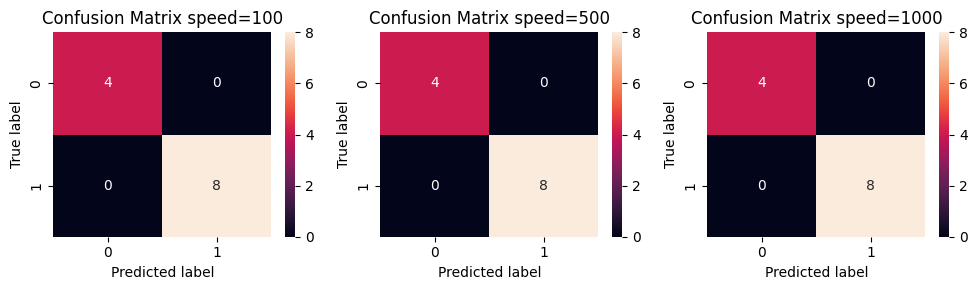

In [395]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

matrices=[]
for speed in speeds:
    print('Speed', speed, 'model')
    y_pred = clf_dict[speed].predict(X_test_dict[speed])
    accuracy = accuracy_score(y_test_dict[speed], y_pred)
    precision = precision_score(y_test_dict[speed], y_pred, average='macro')
    recall = recall_score(y_test_dict[speed], y_pred, average='macro')
    f1 = f1_score(y_test_dict[speed], y_pred, average='macro')
    print("accuracy :", accuracy)
    print("precision :", precision)
    print("recall :", recall)
    print("f1 :", f1)
    cm = confusion_matrix(y_test_dict[speed], y_pred)
    matrices.append(cm)
    print('###########################')

for i, ax in enumerate(axes.flat):
    if i==3 :
        break
    sns.heatmap(matrices[i], annot=True, fmt='d', ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'Confusion Matrix speed={speeds[i]}')

plt.tight_layout()
plt.show()

In [396]:
clf_dict_final = {}
for speed in speeds :  
    params = clf_dict[speed].best_params_
    # params_save =  {'bootstrap': False, 'max_depth': 10, 'n_estimators': 10}
    clf_dict_final[speed] = RandomForestClassifier(**params_shift)
    clf_dict_final[speed].fit(X_dict[speed],y_dict[speed])

In [417]:
def predict(X, Speed, clf_dict):
    n = len(X)
    prediction = [-1]*n
    for i in range(n):
        x = X.loc[[i]]
        speed = Speed[i]
        pred = clf_dict[speed].predict(x)
        prediction[i] = pred[0]
    return prediction


df_test_1 = read_test_data(0)
X_test_1, Speed_test_1 = preprocess(df_test_1, scaler, X_backup, id_to_keep1, return_speed = True)
# X_test_1 = X_test_1.drop(['500','1000'], axis=1)
# Speed_test_1 = df_test_1['Speed']
predict(X_test_1, Speed_test_1, clf_dict_final)
# X_test_1.loc[[0]]

Index(['VIB1: aRMS min', ' VIB1: aRMS avg', ' VIB1: aRMS max',
       'VIB1: vRMS min', ' VIB1: vRMS avg', ' VIB1: vRMS max', 'VIB1: DKW min',
       ' VIB1: DKW avg', ' VIB1: DKW max', 'VIB1: aPeak min',
       ' VIB1: aPeak avg', ' VIB1: aPeak max', 'Speed', '500', '1000'],
      dtype='object')


[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

In [415]:
df_test_2 = read_test_data(2)
X_test_2, Speed_test_2 = preprocess(df_test_2, scaler,X_backup,id_to_keep1, speed_missing=True, return_speed = True)
# X_test_2 = X_test_2.drop(['500','1000'], axis=1)
# Speed_test_1 = df_test_1['Speed']
predict(X_test_2, Speed_test_2, clf_dict_final)

null values detected
Index(['VIB1: aRMS min', ' VIB1: aRMS avg', ' VIB1: aRMS max',
       'VIB1: vRMS min', ' VIB1: vRMS avg', ' VIB1: vRMS max', 'VIB1: DKW min',
       ' VIB1: DKW avg', ' VIB1: DKW max', 'VIB1: aPeak min',
       ' VIB1: aPeak avg', ' VIB1: aPeak max', 'Speed', '500', '1000'],
      dtype='object')


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]